In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Zad.1

In [3]:
def random_population(chromosome_length, mi, x_bounds, sigma):
    res=np.full((mi, 2, chromosome_length), 0.0)
    for num_of_child in range(mi):
        res[num_of_child, 0, :]=np.random.uniform(x_bounds[0], x_bounds[1], chromosome_length)
        res[num_of_child, 1, :]=np.full(chromosome_length, sigma)
    return res

In [4]:
def parent_selection(P, evaluation_result, lambda_param):
    indices=np.random.choice(len(evaluation_result), lambda_param)
    return P[indices]

In [5]:
def mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length):
    for i in range(lambda_param):
        epsilon_zero = tau_param * np.random.normal(0, 1, 1)
        epsilons_i = tau_zero_param * np.random.normal(0, 1, chromosome_length) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        tmp2 = np.array(P_children[i, 0, :])
        epsilons_for_first_chromosome = np.random.normal(0, 1, chromosome_length) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
    return P_children

In [6]:
def replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda=True, looking_for_max=False):
    if not is_mi_plus_lambda:
        indices=np.argsort(-children_evaluation_result)[:mi_param] if looking_for_max else np.argsort(children_evaluation_result)[:mi_param]
        return  P_children[indices], children_evaluation_result[indices]
    else:
        all_evaluation_results=np.concatenate((evaluation_result, children_evaluation_result))
        full_population=np.concatenate((P, P_children))
        indices=np.argsort(-all_evaluation_results)[:mi_param] if looking_for_max else np.argsort(all_evaluation_results)[:mi_param]
        return full_population[indices], all_evaluation_results[indices]

In [7]:
def eval_population(objective_function, population):
    population_size=len(population)
    results=np.zeros(population_size)
    for i in range(population_size):
        results[i] = objective_function(population[i])
    return results

In [27]:
def ES_mi_lambda(objective_function, chromosome_length, mi_param, lambda_param, x_bounds, number_of_parents=2, sigma=1, is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=500, looking_for_max=False):
    if tau_param is None:
        tau_param=1/np.sqrt(2*chromosome_length)
    if tau_zero_param is None:
        tau_zero_param=1/np.sqrt(2*np.sqrt(chromosome_length))
    min_evaluation_results=np.empty(iterations_number)
    mean_evaluation_results=np.empty(iterations_number)
    max_evaluation_results=np.empty(iterations_number)
    best_solutions=np.empty((iterations_number, chromosome_length))    
    sigmas=[]
    P=random_population(chromosome_length, mi_param, x_bounds, sigma)
    evaluation_result=eval_population(objective_function, P[:, 0, :])
    for i in range(iterations_number):
        max_evaluation_results[i] = np.max(evaluation_result)
        mean_evaluation_results[i] = np.mean(evaluation_result)
        min_evaluation_results[i] = np.min(evaluation_result)
        best_index = evaluation_result.argmax() if looking_for_max else evaluation_result.argmin()
        best_solutions[i] = P[best_index, 0, :]
        sigmas.append(np.mean(P[:, 1, :]))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length)
        children_evaluation_result=eval_population(objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, 
                                          is_mi_plus_lambda=is_mi_plus_lambda, looking_for_max=looking_for_max)
        if i % 100 == 0:
            if looking_for_max:
                print(f"Iter: {i}, best result: {max_evaluation_results[:i+1].max()}, mean result: {mean_evaluation_results[i]}")
            else:
                print(f"Iter: {i}, best result: {min_evaluation_results[:i+1].min()}, mean result: {mean_evaluation_results[i]}")
    best_score = max_evaluation_results.max() if looking_for_max else min_evaluation_results.min()
    best_score_idx = max_evaluation_results.argmax() if looking_for_max else min_evaluation_results.argmin()
    return best_solutions[best_score_idx], max_evaluation_results, mean_evaluation_results, min_evaluation_results, sigmas, best_score

In [28]:
def plot_chart(P):
    plt.figure(figsize=(20, 7))
    plt.plot(P[1], label="Max results")
    plt.plot(P[2], label="Mean results")
    plt.plot(P[3], label="Min results")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.show()
    plt.figure(figsize=(20, 7))
    plt.plot(P[4], label="Sigmas mean")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.show()

## Benchmarks: other interesting: Dixon & Price, Zhakaraov, Trid, Booth

Sphere

14.0
20
Iter: 0, best result: 80.12562767794483, mean result: 173.93234303158366
Iter: 100, best result: 0.03025516870141581, mean result: 0.06052040058907662
Iter: 200, best result: 0.0004917784940254059, mean result: 0.0005363267574861042
Iter: 300, best result: 7.13342393379789e-05, mean result: 7.210518014199465e-05
Iter: 400, best result: 4.297341952661214e-06, mean result: 2.6841095942389574e-05


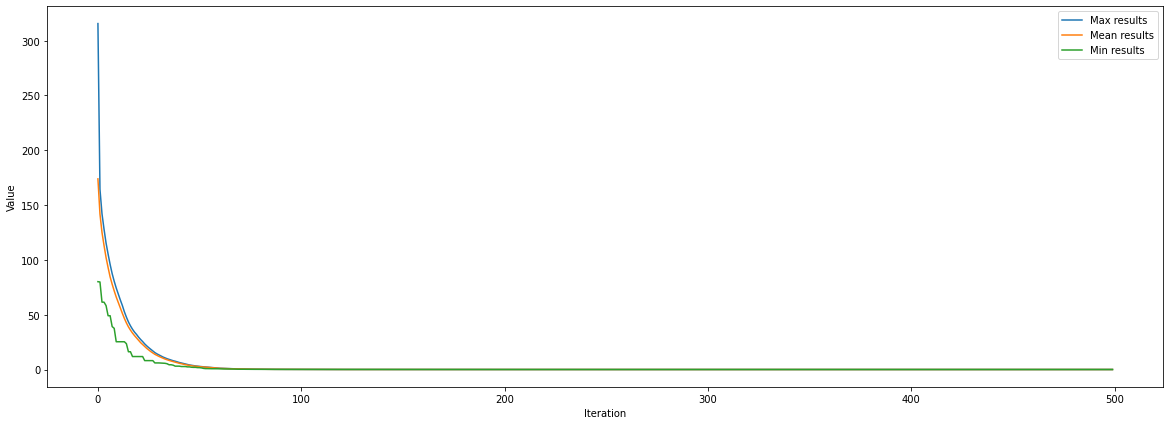

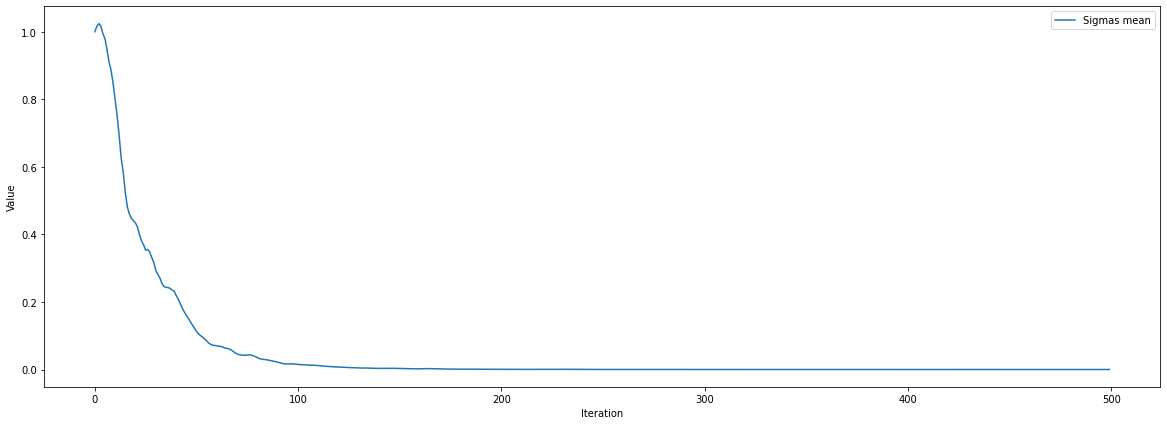

4.735712761101834e-09
[-2.33377453e-05 -1.99684629e-06  6.36520277e-06  2.79065334e-06
  7.08021686e-06 -3.29748092e-06  8.50862982e-06  1.55522378e-05
  4.65302373e-07  6.04648726e-06  3.92792250e-06  7.33901709e-06
  3.51495071e-05  8.17403282e-06  8.33645822e-06 -6.32760370e-06
 -4.44255688e-07  5.07959238e-06  4.66634161e-05  6.49012106e-06]
50
Iter: 0, best result: 276.3526701706658, mean result: 436.2376294484288
Iter: 100, best result: 18.917489541990747, mean result: 21.816896986944347
Iter: 200, best result: 6.9808724068240675, mean result: 7.360958855391742
Iter: 300, best result: 5.439555536735965, mean result: 5.46640448226969
Iter: 400, best result: 1.4707371706536405, mean result: 1.4942304248849678


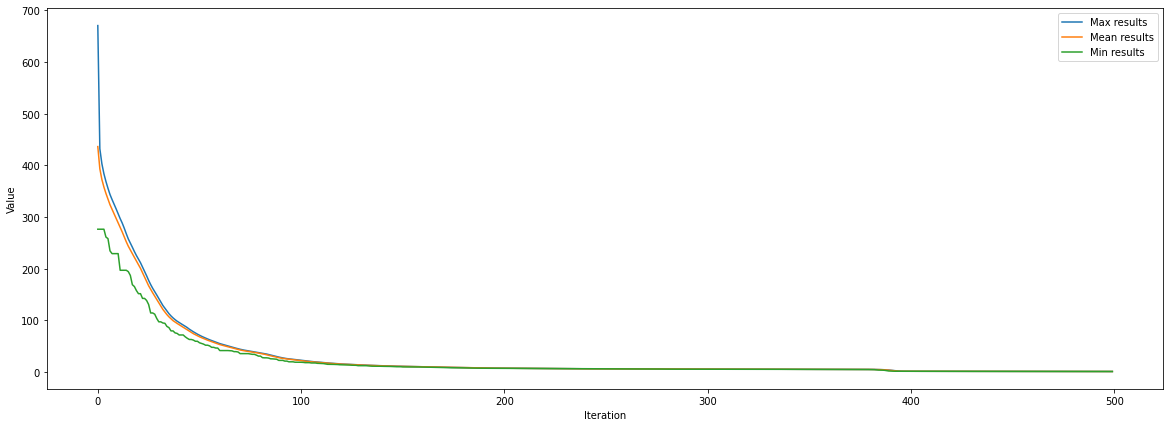

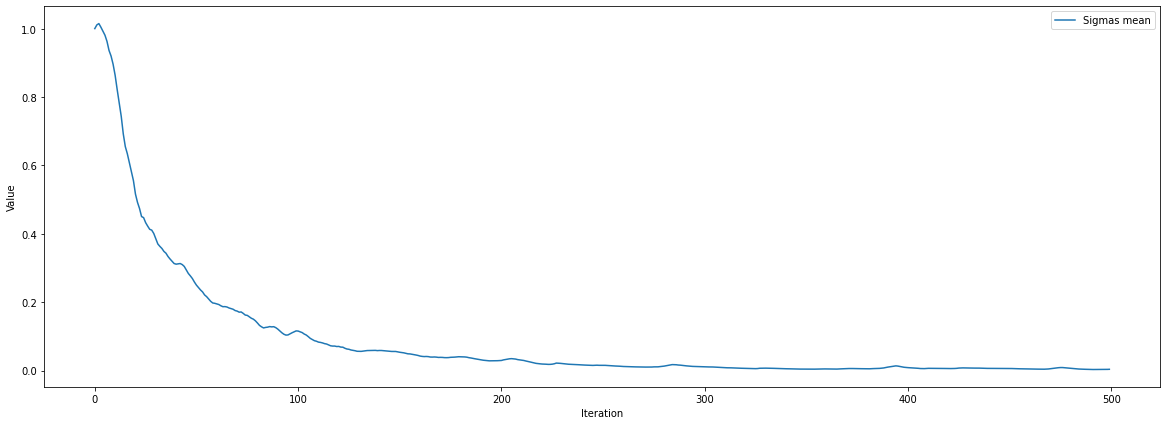

1.034901182023743
[-5.66168323e-01 -6.57669201e-03 -1.70184100e-01 -5.36275816e-02
  1.87714390e-02  5.52586405e-03  4.22569787e-04  1.77840489e-02
 -2.83159167e-04 -2.44204238e-02  4.74733967e-03  4.28667048e-02
 -3.65007568e-03  1.61862766e-01  5.87219788e-02  3.66744464e-03
 -4.94482144e-02 -1.11408509e-01  4.62687923e-02 -5.58852215e-02
 -4.51905366e-02 -1.58850719e-02 -1.05449799e-02 -8.17462466e-03
 -1.81137286e-03 -7.51707949e-01  1.20078999e-02  1.53074163e-02
  4.00943133e-02 -1.75142604e-02  1.29671587e-02 -2.59571536e-02
  4.30071564e-02 -1.28631364e-01 -1.83737942e-02 -2.95777831e-02
  1.13248413e-02  3.67637393e-03 -1.89785869e-02  2.23850298e-02
 -1.66175763e-02  4.87268940e-02  8.10600640e-02  5.49474706e-02
  4.64310446e-02 -8.49738368e-02  2.22261321e-02 -2.70615104e-02
 -1.23430397e-01 -1.25168783e-02]
100
Iter: 0, best result: 620.3398122135704, mean result: 876.1047092106284
Iter: 100, best result: 234.38150416828248, mean result: 252.17384327527324
Iter: 200, best 

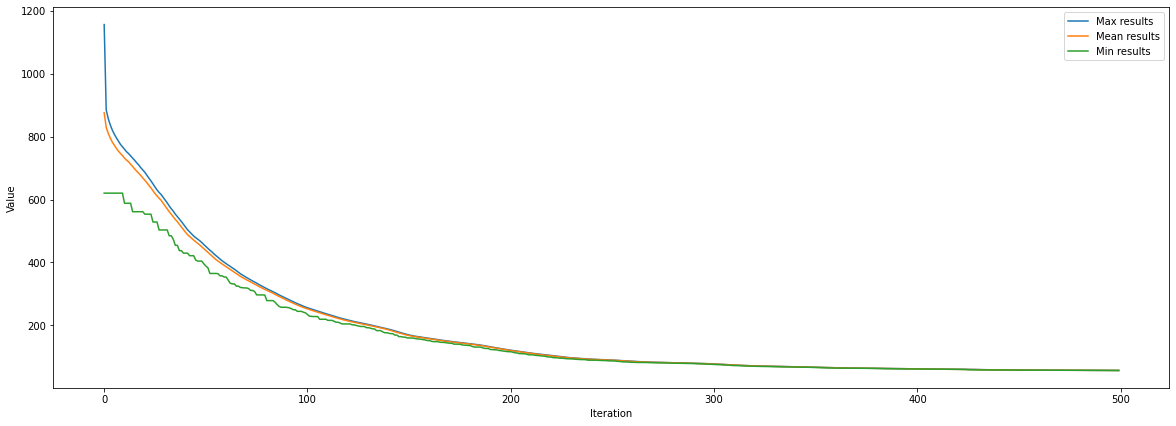

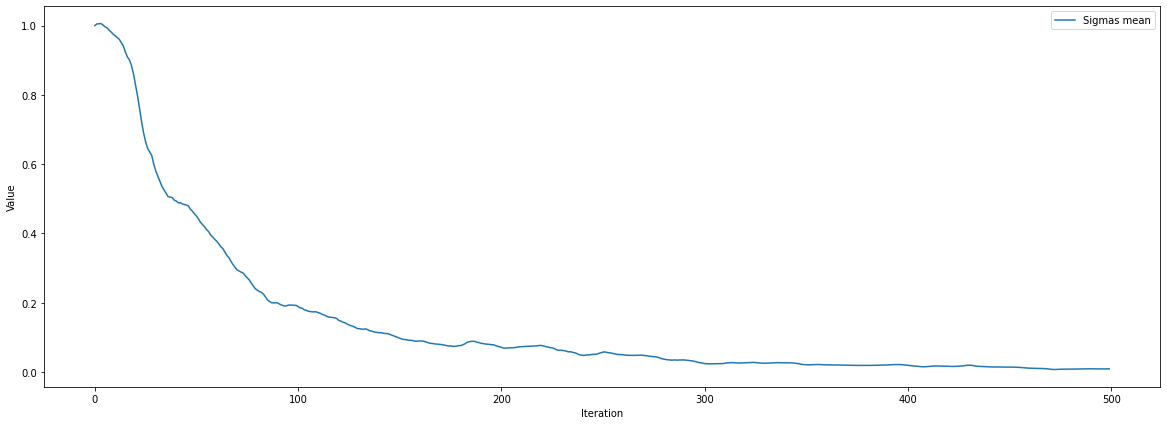

56.24358779220078
[-1.84488018e-01  2.29655117e+00 -5.05504978e-02  2.15645148e-01
  2.03833158e-01 -7.50125517e-02  2.00004815e-01 -2.62127045e-01
 -4.64756821e-01 -9.23421018e-02  3.52425616e-02  3.21683829e-01
  3.32775205e-02 -9.87081387e-01  4.86814542e-02  3.44298210e-02
 -2.36733929e-03  1.21505267e-01 -3.87285052e-02  7.40783130e-02
  9.02501324e-01 -1.90167507e-01 -6.11780496e-01 -1.23122205e-02
 -1.21648836e-01  2.38103501e-01 -2.89306521e-01 -6.37780973e-02
 -7.92897696e-02  3.25302660e-01 -5.01390383e-02  2.64536362e-01
 -1.47412383e-02  6.11423098e-02 -8.62816572e-02 -1.59287238e-01
 -1.31063799e-01 -1.40394191e-01 -5.87198158e-02 -1.45701234e-01
 -2.30934741e-01  8.74430442e-02 -7.38447926e-02 -8.19152906e-03
 -6.55240354e-01  1.92669438e+00  1.08771065e-01  5.68401827e-01
 -1.19787249e+00  2.76085876e-01 -1.35747241e-01 -6.16561934e-01
 -2.20994797e-01  1.97844983e-01 -1.00559109e-01 -1.71896366e-01
  1.90898328e-01  8.40450955e-02 -9.34103473e-02  2.19924814e+00
  7.795

In [29]:
def sphere(individual):
    return np.sum(individual * individual)
print(sphere(np.array([1.0, 2.0, 3.0])))

for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(sphere, chromosomes, 800, 2000, (-5.12, 5.12))
    plot_chart(res)
    print(res[5])
    print(res[0])

20
Iter: 0, best result: 76.2714483752591, mean result: 175.52424196008178
Iter: 100, best result: 0.8465863772168252, mean result: 1.1656984202607763
Iter: 200, best result: 0.014535058983307675, mean result: 0.022615649370283205
Iter: 300, best result: 0.0005121920215967214, mean result: 0.0005841050566514675
Iter: 400, best result: 0.0002855083505808732, mean result: 0.0002882358124005845


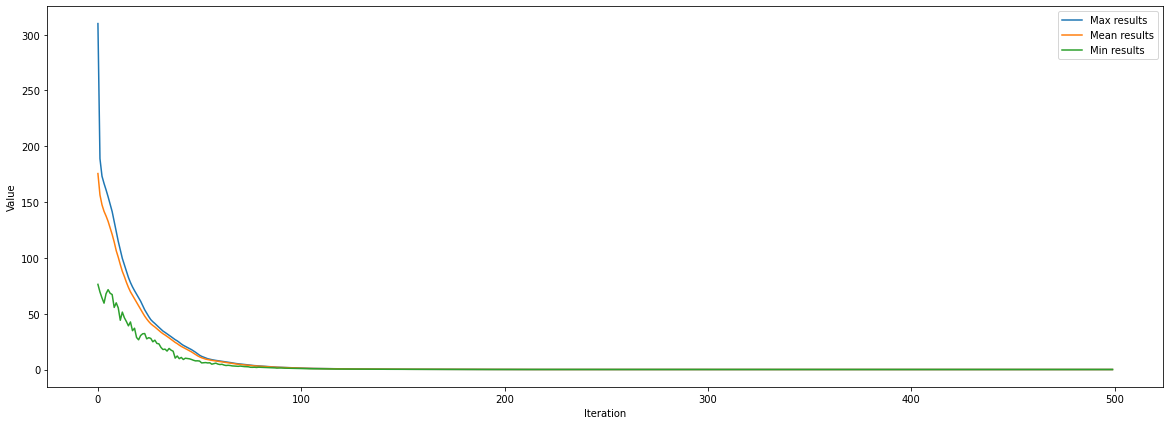

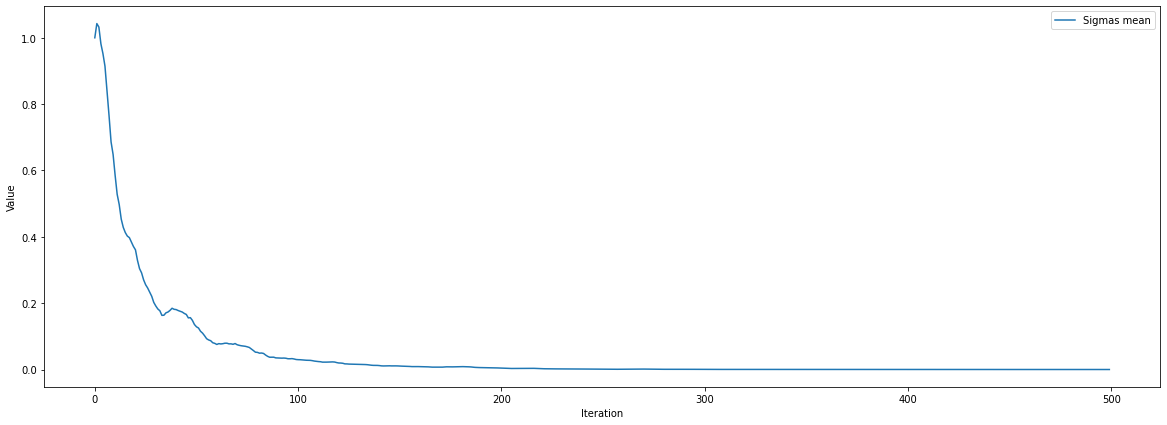

3.939923419502691e-06
[-1.92712373e-04 -8.23214269e-04  6.90567123e-05 -1.54198292e-04
 -1.83525302e-04  1.53536659e-03  4.93822199e-05 -1.29529456e-05
 -1.47958339e-04  4.56043425e-04  1.52669677e-04 -1.17537824e-05
 -3.22864686e-04 -5.74042656e-04 -2.10751222e-05 -1.06466214e-04
 -2.65346973e-04  1.55464360e-04  1.10765186e-05  9.67423411e-05]
50
Iter: 0, best result: 248.1536628123486, mean result: 436.50509682430413
Iter: 100, best result: 63.56768456375272, mean result: 71.20257045818012
Iter: 200, best result: 26.85000329874576, mean result: 29.228423845672243
Iter: 300, best result: 9.787484538899905, mean result: 10.361647138409642
Iter: 400, best result: 5.179088963261108, mean result: 5.294810468147952


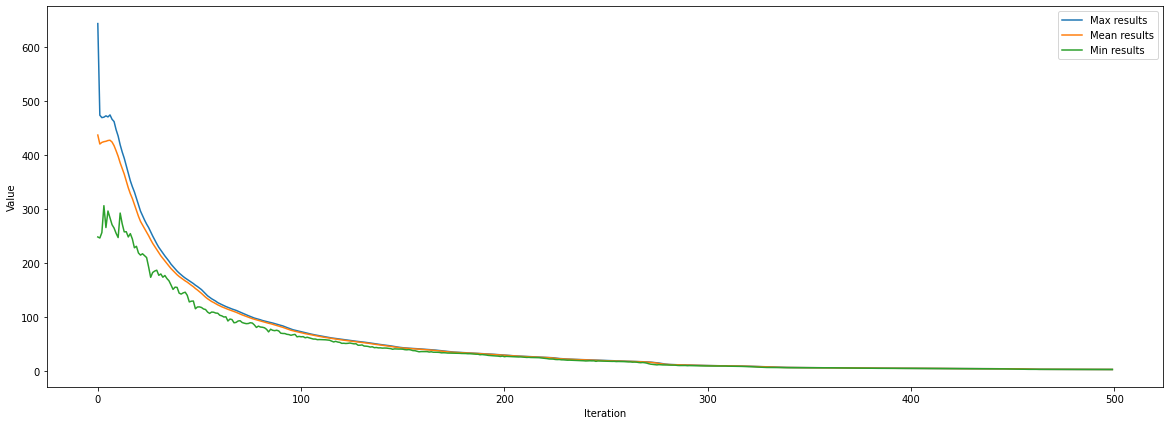

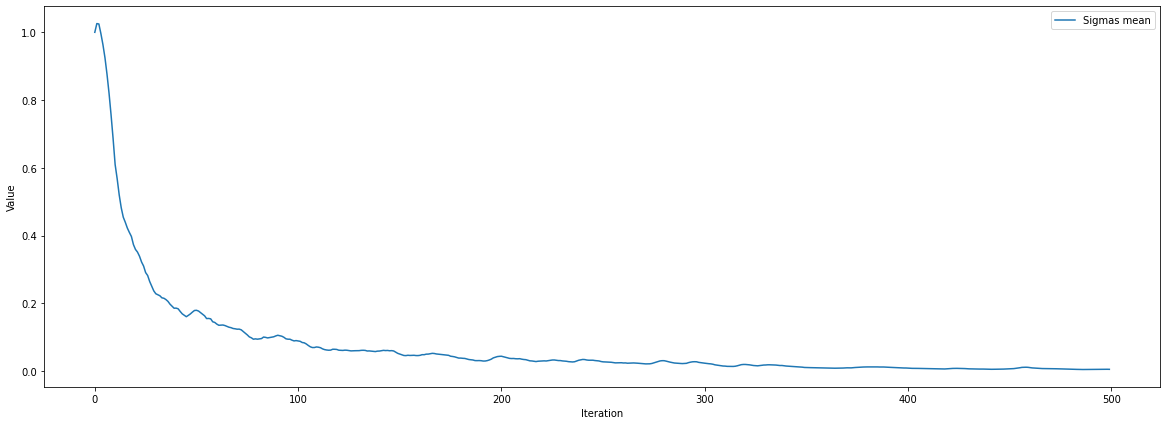

3.1784957417878883
[ 1.52803110e-02 -5.01043959e-03 -1.00738183e-01 -3.43193904e-01
  1.69853716e-01 -1.40087371e-01 -2.65765529e-02 -1.34345695e-01
  8.79555536e-02  1.68326648e-02  1.26675506e-01  5.41973272e-02
  5.76280361e-02 -5.28783987e-02  3.32898969e-02 -3.14579359e-02
  3.99967741e-01 -5.01335574e-01  4.09214667e-02 -2.57367597e-01
 -1.51767128e-02 -7.03133561e-02  7.18790509e-01 -6.16941611e-02
 -1.40940452e-01  8.10831501e-02 -1.25951217e-01 -1.84468309e-01
  5.40314059e-04  5.04270562e-02 -2.97705180e-01  7.53146456e-01
 -8.08362804e-02 -7.95476189e-02  2.01294241e-01 -2.55180952e-02
  1.53727411e-01 -2.79251915e-01  2.53736090e-01  3.42918904e-02
 -9.43855919e-01 -1.43082141e-01 -6.86754051e-02  2.09689926e-01
 -4.93507346e-02  3.37290172e-02 -1.40008543e-01  4.08117397e-02
  3.60851093e-02  2.98586513e-02]
100
Iter: 0, best result: 629.2545829670485, mean result: 875.181097544182
Iter: 100, best result: 344.82370532500124, mean result: 381.60588741503597
Iter: 200, best 

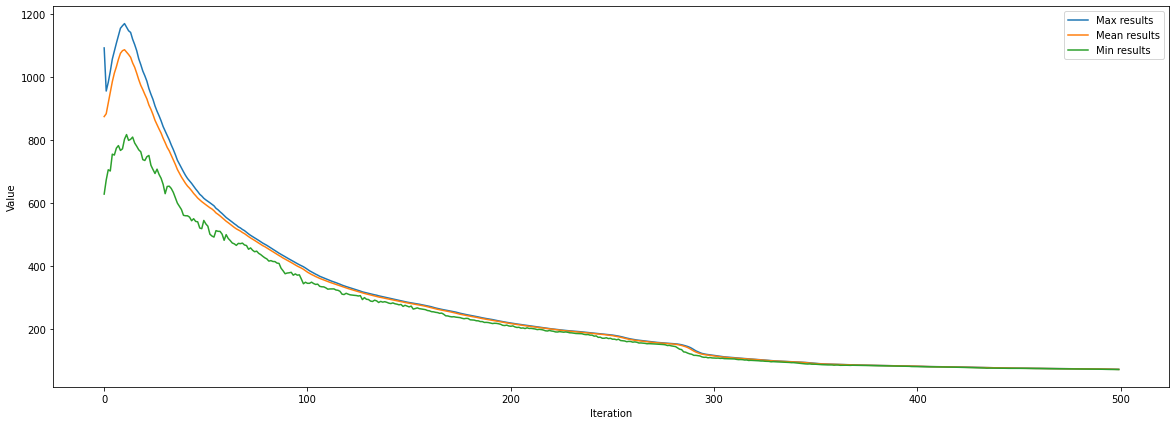

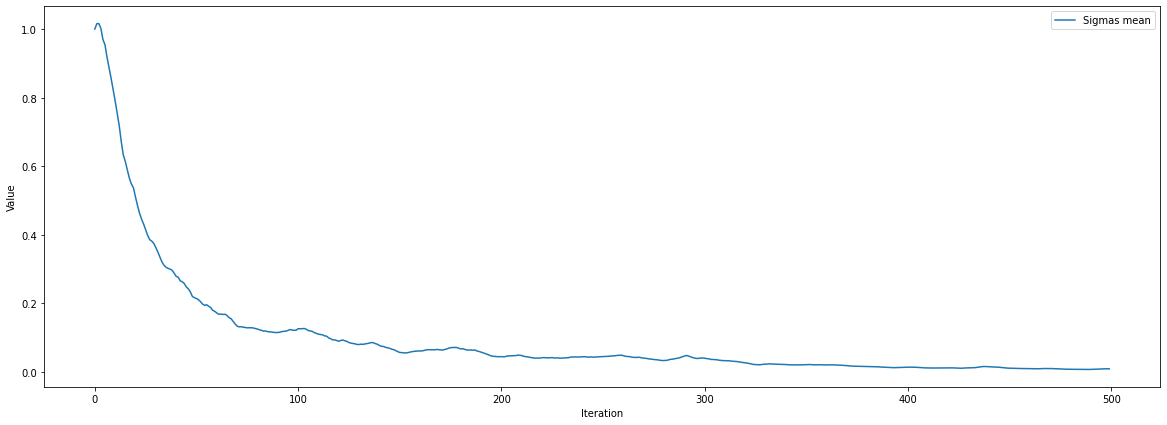

72.82535722634744
[-0.73996669 -0.12431286  2.76933334  0.80307266 -0.26068808  0.17328036
  0.86674029 -0.1986725   0.73735312 -0.03928265 -0.18815938  0.02440345
  0.19301069  0.37129927 -0.04235066  0.69214884 -0.80696111  0.05881815
 -0.11331754 -0.18350164 -1.42786703  0.0130092  -0.05915954  1.49795593
 -0.33328511  0.0139981  -0.0305172   0.89286805  0.04080728 -0.29617164
  0.11050705  1.21830166 -0.25014589 -1.60811792  0.15302426 -0.11173425
  0.2341603  -0.51573658  0.04058186  0.33211504 -0.10278556  0.09535417
  1.2137151  -0.03959234 -0.18690719  0.06811918  0.4361811  -0.31461921
  1.0635076   0.16777272 -0.18200591 -0.37443595  1.45841411 -0.16949393
  0.15002025  0.08368613 -0.42661457 -0.26707227 -0.24334605 -0.07923244
  0.26306037  0.39970957 -0.00712821  0.98009752  0.21629977  0.35659029
  2.11711299  1.70796385 -1.09108868 -0.13748862  1.537894   -0.84484617
 -0.13520991  0.74901602 -0.21055644  1.34552819 -0.34251712  0.0816634
 -0.65633101 -0.35838177  0.212884

In [30]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(sphere, chromosomes, 800, 2000, (-5.12, 5.12), is_mi_plus_lambda=False)
    plot_chart(res)
    print(res[5])
    print(res[0])

Sum squares

36.0
20
Iter: 0, best result: 2642.178988472201, mean result: 6931.902998042593
Iter: 100, best result: 1.9932854765108141, mean result: 3.0134108886272886
Iter: 200, best result: 0.03516963146588755, mean result: 0.04659726098593904
Iter: 300, best result: 0.0003451382038575096, mean result: 0.00037904573973604206
Iter: 400, best result: 1.0252928404753606e-06, mean result: 1.349751586988785e-06


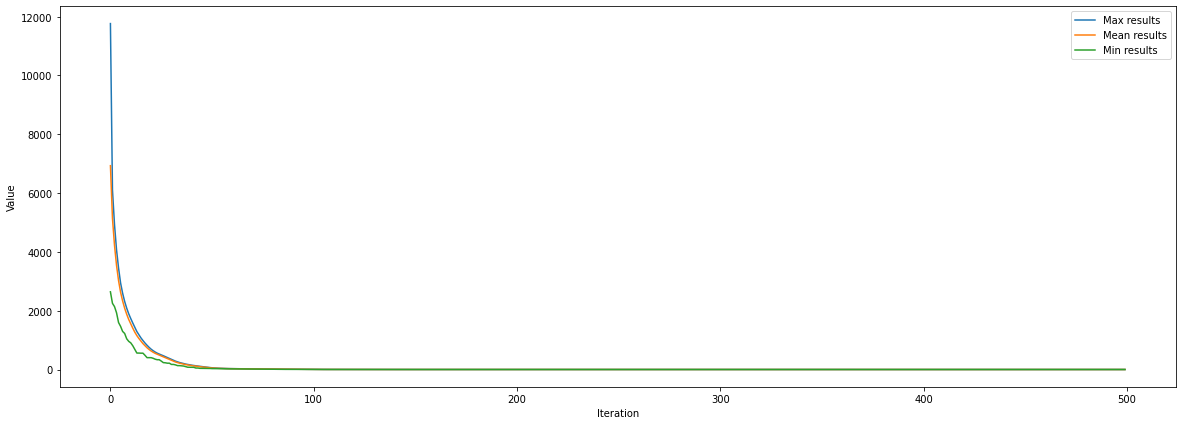

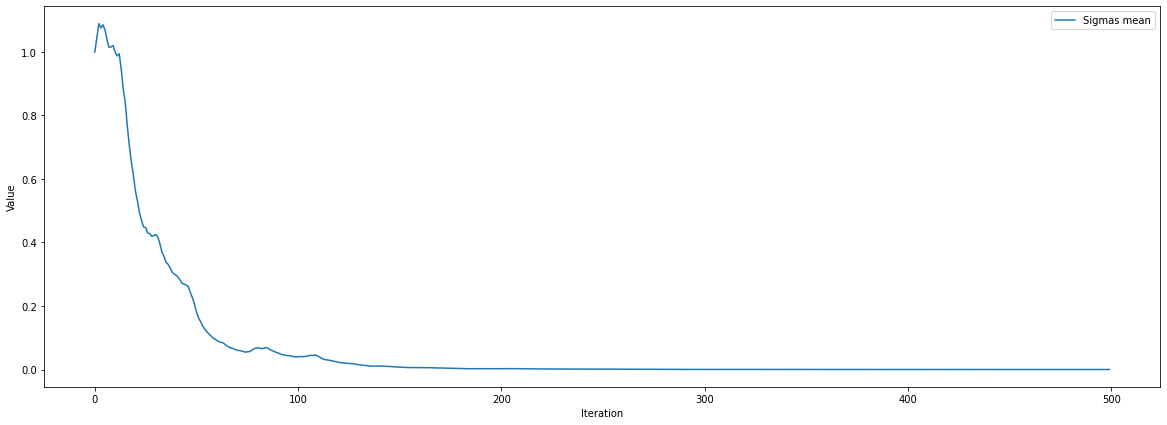

8.020627777939578e-09
[-1.41217804e-06  7.25231935e-06 -2.20415348e-06  3.62144156e-06
 -4.26437358e-06 -9.32525323e-07  2.10565425e-06  3.98404522e-06
  1.65160580e-06  8.14445377e-08  1.97476797e-06  2.86062773e-06
  1.58395913e-06  4.10669307e-07  1.43465265e-06 -2.20540432e-06
  2.06364664e-05  6.39265063e-07 -1.17928946e-06  6.85607466e-07]
50
Iter: 0, best result: 25808.143837861604, mean result: 42227.791264064166
Iter: 100, best result: 1386.471230365367, mean result: 1519.0424472531074
Iter: 200, best result: 584.4254361139842, mean result: 603.3742335519842
Iter: 300, best result: 287.5980304114886, mean result: 289.8795728366011
Iter: 400, best result: 84.89662421765213, mean result: 85.65026972911002


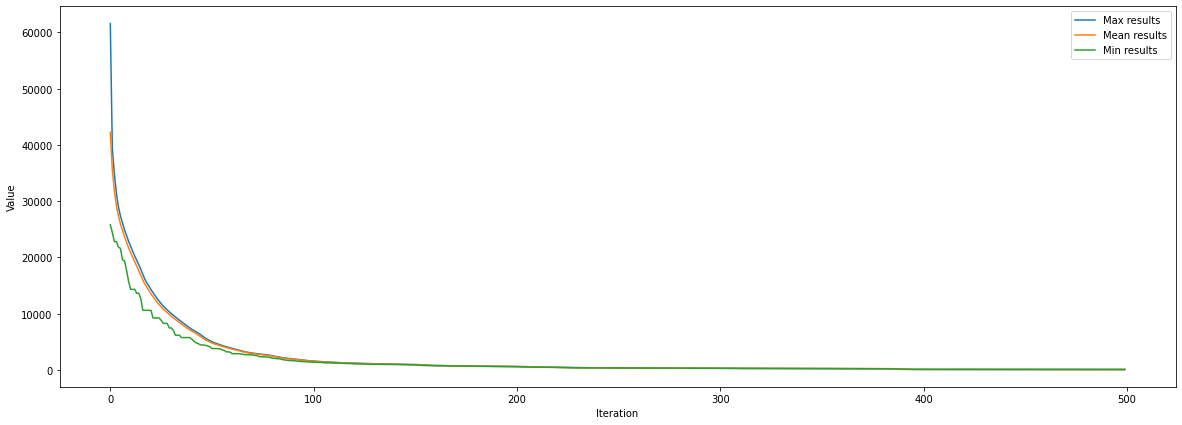

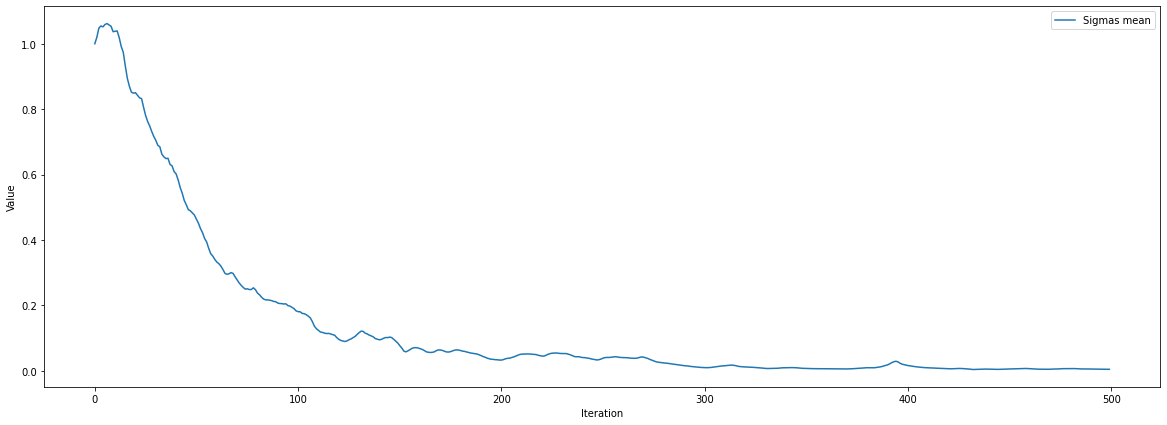

68.3169923004804
[ 0.16059788 -0.06199119 -0.28822029 -0.0629562   0.05183465  0.02933992
 -0.04951323 -0.03242306 -0.02552794  0.50993305  0.03597887  0.05007249
  0.16830327 -0.03452528  1.34379808  0.08066874  0.07711402 -0.00905942
 -0.01308233  0.01820524  0.03623909 -0.07319184  0.13138845  0.0016015
 -0.02959486 -0.82829703  0.00945326  0.02118997 -0.07858011 -0.0190822
 -0.0054461  -0.01594083 -0.0165544   0.01906236  0.04195003  0.16778538
  0.05098991  0.08394131  0.00586784 -0.16552798 -0.04298968 -0.04018073
 -0.01287548  0.02636374  0.0326431   0.02237682  0.02393913  0.579875
  0.02515863 -0.01464815]
100
Iter: 0, best result: 112236.23833058322, mean result: 169188.31603562017
Iter: 100, best result: 26150.425510779514, mean result: 27839.405178897214
Iter: 200, best result: 11858.005471949824, mean result: 12113.683734115755
Iter: 300, best result: 9139.227331047307, mean result: 9196.034542210033
Iter: 400, best result: 7637.915687069166, mean result: 7671.08377829158


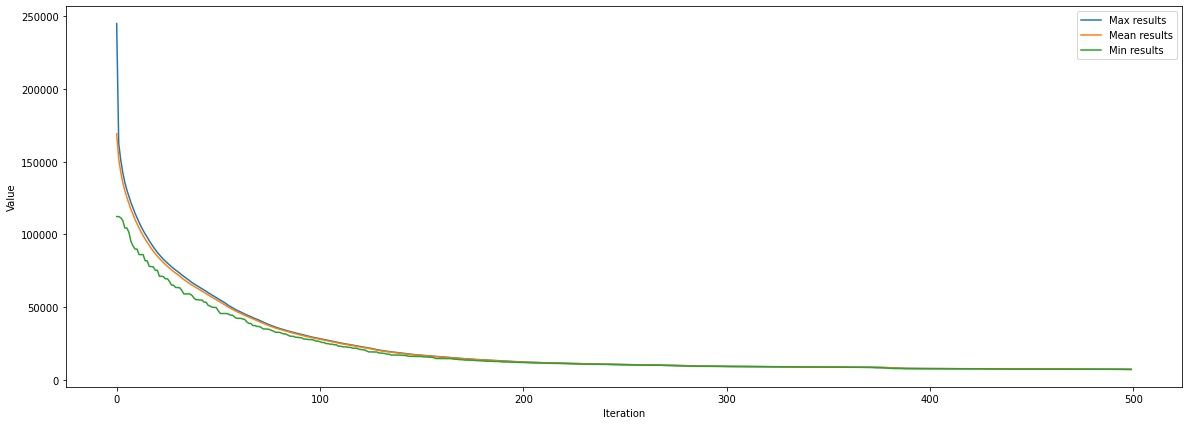

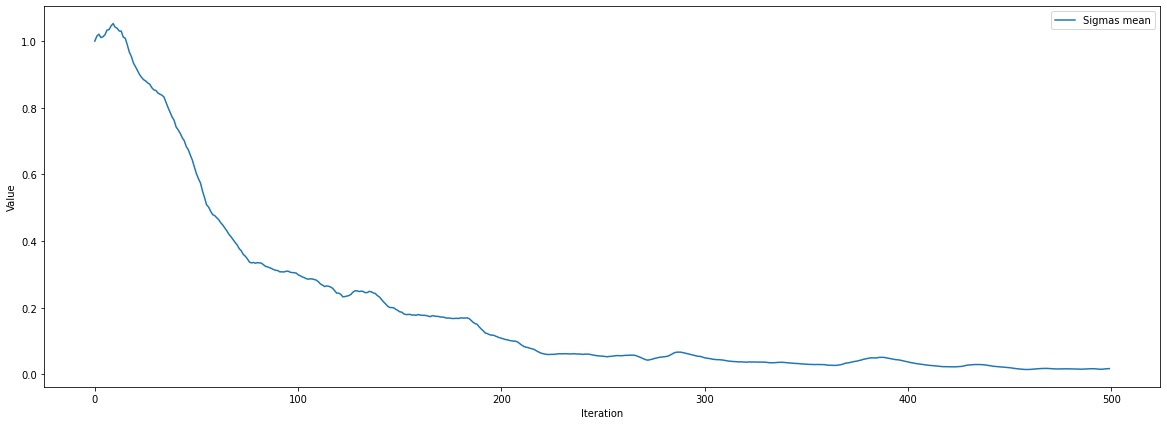

7058.3527842916565
[ 1.10552289  0.77929463 -4.21182886 -1.68440065 -1.30016718 -0.39454554
 -0.53006066  0.09737503 -0.16004421 -1.90826269  0.6000311   0.06160708
  0.49068705  0.08476859 -0.17668392 -4.9135884  -0.32639096  0.07881752
 -0.38100093 -0.72440691 -0.77256001  6.34322035  0.19030006  0.1597395
 -0.11978666  0.32567915  0.05705908  0.17782038  0.1628765  -0.09165038
 -0.27840447 -0.19584118  0.07657063  2.77241264  0.10209148  0.5675897
 -0.22672594  0.43218235 -0.31447836  0.09404811  3.6882104  -0.53815313
  0.05738631 -0.17434189  1.33613299 -0.34293654  0.98118806  0.10709502
  0.11655303  0.04614786  0.40173534  3.1973709   0.47136521  0.04884531
 -0.02839752  0.09517935 -0.32878874  0.19192796 -0.44057738 -0.29471127
  1.13533552  0.09936368  0.18395417 -0.06117489  0.65426107  0.02162581
  0.04264622 -0.08543262  0.26976413 -0.01595848 -0.37145232 -0.02356184
  0.43918356  0.02486096  0.19429687 -0.25344551  0.06710376 -0.97582279
  0.06511053 -0.1214855  -0.157296

In [31]:
def sum_squares(individual):
    return np.sum(np.arange(1, len(individual) + 1) * individual * individual)
print(sum_squares(np.array([1.0, 2.0, 3.0])))
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(sum_squares, chromosomes, 800, 2000, (-10, 10))
    plot_chart(res)
    print(res[5])
    print(res[0])

20
Iter: 0, best result: 2804.251059082835, mean result: 7035.370003997832
Iter: 100, best result: 51.72913896872818, mean result: 65.01481608897524
Iter: 200, best result: 3.06417449859904, mean result: 3.4753555044309237
Iter: 300, best result: 0.07735252998497749, mean result: 0.08730848462201868
Iter: 400, best result: 0.04657245891324966, mean result: 0.05086536919504236


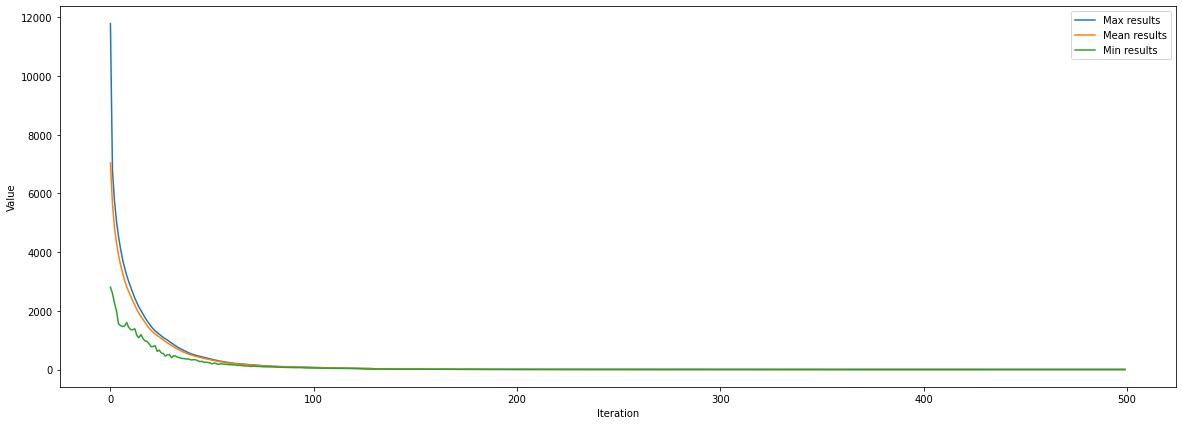

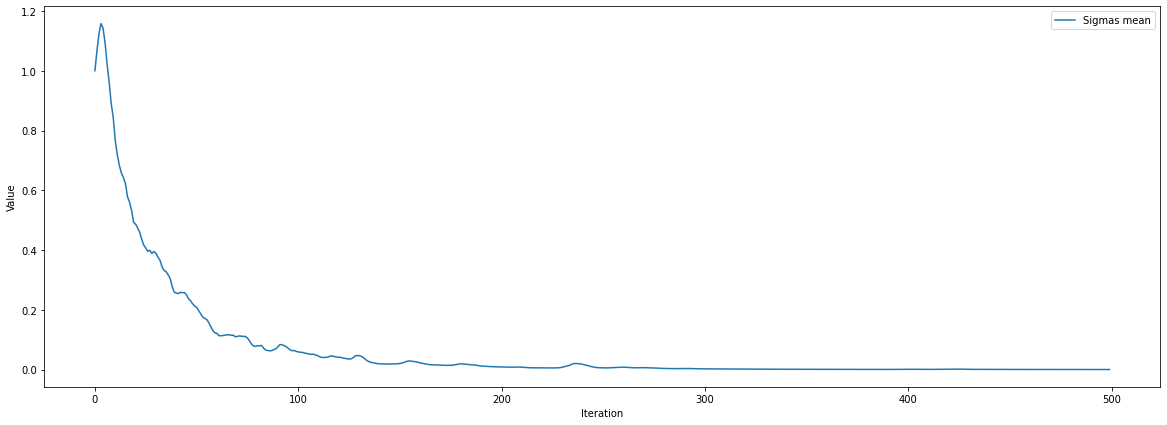

3.7935190785235485e-05
[ 1.56233456e-03 -5.56045466e-05  1.44728900e-04  6.24802494e-05
  2.13807514e-04 -2.07489315e-05 -2.57598429e-04 -1.45163815e-03
  8.22985990e-04 -1.87937790e-04  1.12835225e-04  8.83371258e-04
  2.09286203e-04  3.81481770e-05  1.10236141e-04 -1.64987312e-04
  1.17133776e-04 -7.36919653e-05 -9.49074446e-05  9.82619476e-05]
50
Iter: 0, best result: 25851.291067097995, mean result: 42685.4479167608
Iter: 100, best result: 3483.158139355547, mean result: 3964.438219682548
Iter: 200, best result: 1161.474523184433, mean result: 1220.164780260353
Iter: 300, best result: 496.9478713652741, mean result: 515.0939070380739
Iter: 400, best result: 300.52087906149603, mean result: 308.1042504632863


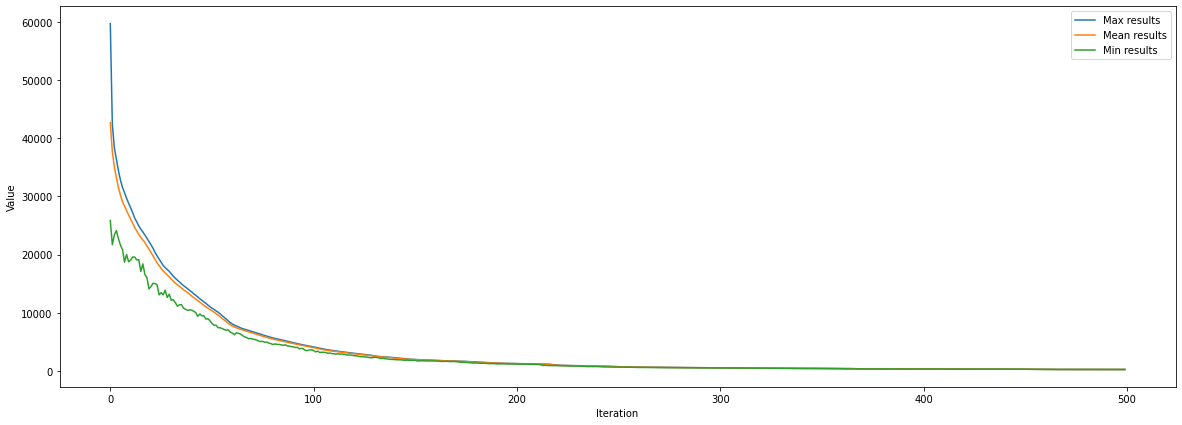

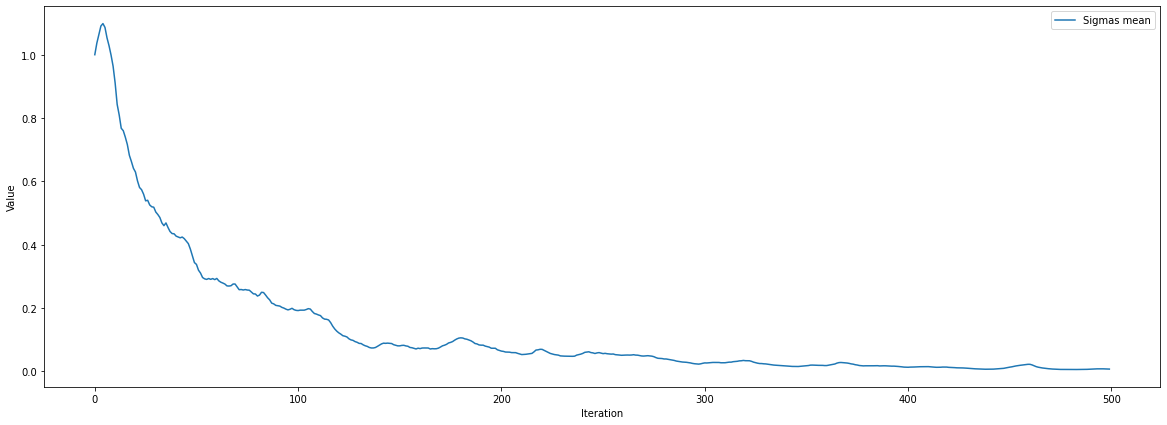

227.48793169834673
[-1.32291061e-01 -7.89593659e-01  3.08498737e+00 -1.91660503e-01
 -1.96505874e-03  1.97551411e-01  1.52305830e-01 -1.16354079e-02
  4.29598337e-02  3.91747450e-02  3.83569720e-02 -5.81498818e-02
 -1.67354974e-01  6.62121041e-01 -3.48815760e-01 -3.80358272e-02
  6.12772495e-02  2.79657778e-02 -1.07388321e-01  1.04484864e-01
  2.00074990e-02  1.47419257e-01 -4.44634987e-01  4.32628187e-02
 -9.58826630e-03 -5.00831973e-02  6.61199367e-01 -5.36141672e-01
 -1.35990033e-02 -1.41294988e+00 -3.86511271e-02 -1.63689212e+00
 -4.19548209e-02  3.86683828e-02  1.16847818e-01 -1.27956948e-01
  3.12235004e-02  2.68456117e-01  2.39870072e-01 -8.10174412e-02
 -1.88921286e-01  3.68590354e-02  2.71944890e-02  8.85654487e-02
 -1.61423630e-02  8.11207021e-02  1.93999102e-02 -3.05419228e-01
  1.51449625e-02 -2.93715278e-01]
100
Iter: 0, best result: 115057.42881956213, mean result: 168304.7694309899
Iter: 100, best result: 45584.66197882559, mean result: 50229.33614689322
Iter: 200, best 

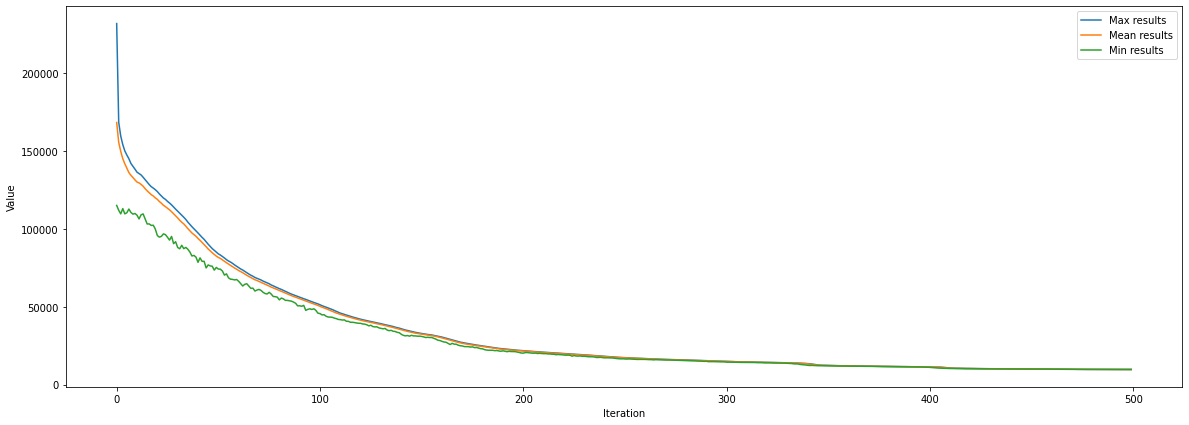

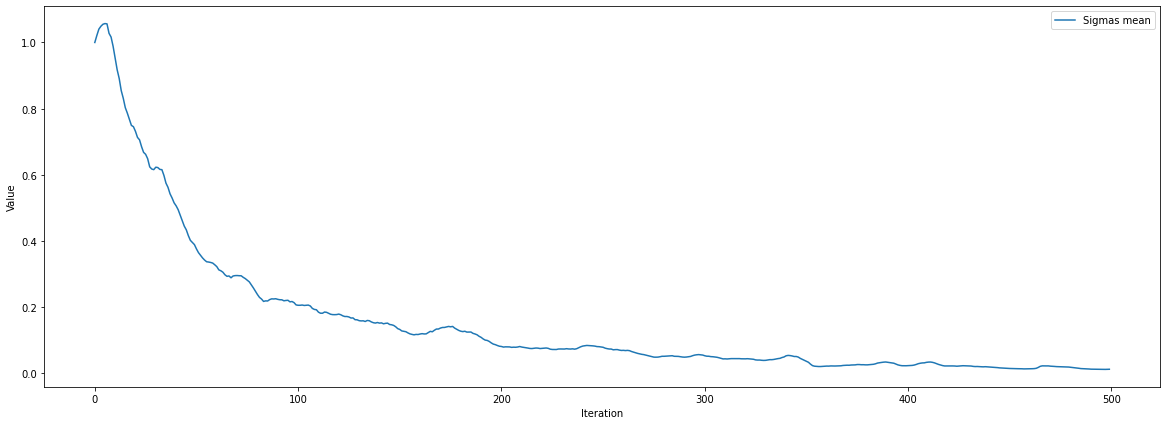

9667.651726050026
[ 3.45391845e+00 -1.61657538e+00  2.60030808e+00 -1.68210180e+00
  3.68938583e+00  2.63295853e-01  1.51006047e+00 -3.14442655e+00
 -1.63263548e+00 -5.12491154e+00 -4.44124278e+00  5.68495074e-01
 -9.70885442e-02 -1.08663571e+00 -3.18526412e-01 -8.44911512e-01
 -2.98522394e-03 -1.10375528e+00  1.65227788e+00  6.43942955e-01
 -1.25841354e-01 -8.54116311e-01  6.37905469e-02 -2.33266289e-02
 -3.09008385e-02 -3.04570598e+00  3.71311917e-02  1.18181048e+00
  6.98003867e-02 -6.46487017e-02 -8.07187318e-01  1.60931878e-01
 -4.68792062e+00 -5.12497546e-01 -3.34726945e+00  7.18746225e-01
 -6.50589808e-01 -2.36078255e+00 -8.69247915e-02 -1.59064848e+00
 -2.48100056e-01 -2.38633466e-01 -1.27747740e-01  6.64446356e-01
  1.16825923e-01 -2.55812699e+00  3.18389481e+00  1.25688973e+00
  4.16855412e+00  6.83551574e-01  3.67185108e-01  6.27596331e-02
  7.73407362e-01  8.33538296e-01  3.44846274e+00  1.60944708e-01
  5.04442965e-01  9.21919084e-02  7.52999399e-03 -1.09070647e-02
 -8.442

In [32]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(sum_squares, chromosomes, 800, 2000, (-10, 10), is_mi_plus_lambda=False)
    plot_chart(res)
    print(res[5])
    print(res[0])

Griewank

In [33]:
def griewank(individual):
    return (np.sum(individual*individual) / 4000) - np.prod(np.cos(individual / np.sqrt(np.arange(1, len(individual) + 1)))) + 1

Mi + lambda

20
Iter: 0, best result: 7.360568115089746, mean result: 17.664874825280304
Iter: 100, best result: 1.1213886292512574, mean result: 1.1993698951927791
Iter: 200, best result: 0.5881540215642924, mean result: 0.8041824318991223
Iter: 300, best result: 0.09762559017771044, mean result: 0.10397220446990094
Iter: 400, best result: 0.06461731631782885, mean result: 0.06493074042242576


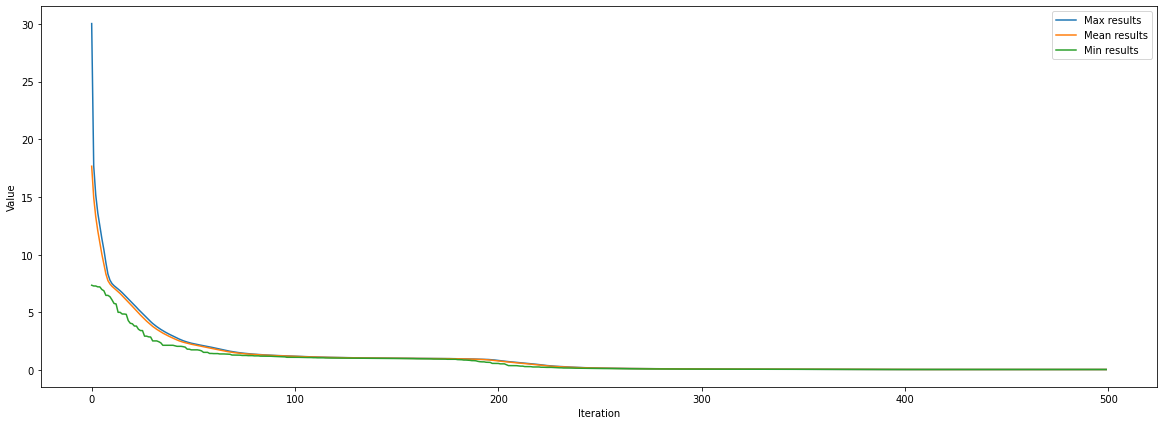

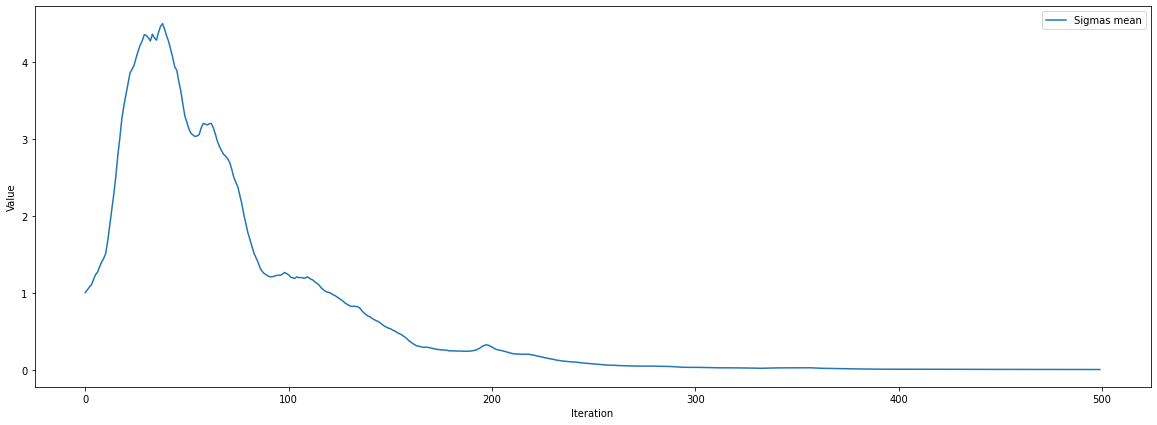

0.06382951326142772
[ 3.13997605e+00  2.15303730e-03 -5.42452443e+00  7.10932043e-04
  7.00907783e+00  7.44914919e-03 -8.64846905e-03 -9.98968469e-03
  1.32270583e-02 -1.04952041e-02  1.22979733e-02 -5.23442626e-03
  5.61475312e-03 -1.11720337e-03 -2.76897169e-03 -6.67073643e-04
  1.28227926e+01  5.97211413e-03  8.52390101e-03 -9.35228632e-03]
50
Iter: 0, best result: 28.594279084422023, mean result: 42.931074905025724
Iter: 100, best result: 8.05967721519658, mean result: 8.973693787323386
Iter: 200, best result: 3.38810858823618, mean result: 3.553759101771216
Iter: 300, best result: 2.469015065261309, mean result: 2.5637169066743146
Iter: 400, best result: 1.644029547162929, mean result: 1.664968301493294


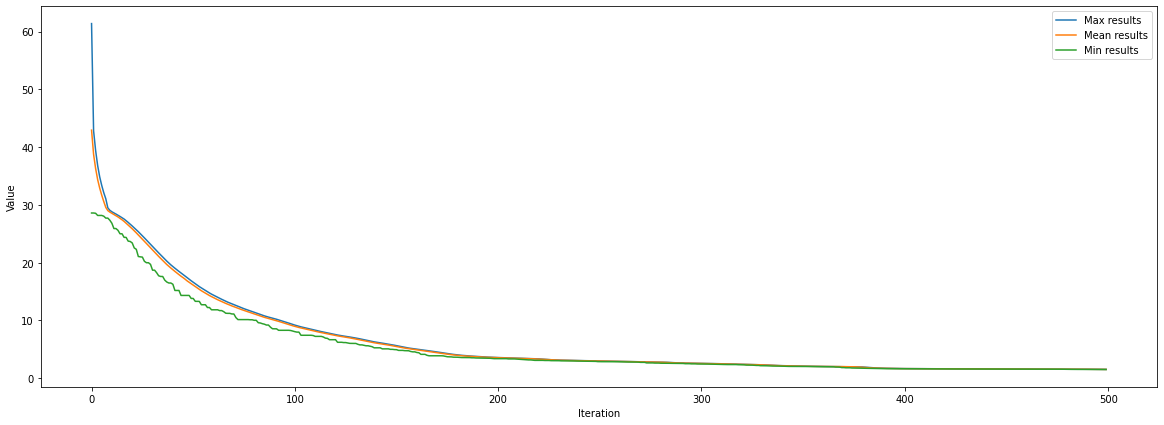

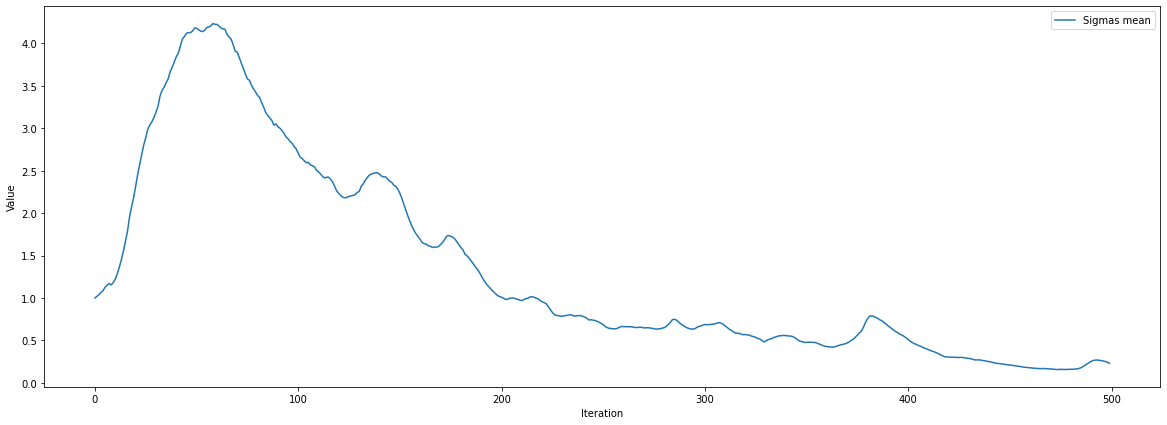

1.5123363060259507
[ 8.56827540e-01 -2.13834032e+00  2.41439132e+00  4.23980043e+00
 -1.93914918e+01 -1.53777650e+00  2.81285679e+00  1.34683611e+00
 -1.90008305e-01  1.03312355e-01 -1.36411169e+01  8.56743470e-01
 -5.51629168e+00 -2.90294381e+00 -5.32173294e+00 -2.51487719e+00
 -4.70245289e-01 -2.23419355e+01 -9.85130806e-01 -3.43301304e-01
 -2.98440412e+00  9.52812101e+00 -3.56781096e-01  3.84882024e-01
 -3.35413761e-01  3.69458964e+00 -6.31944728e-01 -8.94867180e-01
  2.11437026e+01 -1.18498953e+00  2.36436475e+00 -1.18828517e+00
  2.00017690e+00  6.81499322e-01  1.50020725e+01 -3.39429655e+00
 -1.30915463e+00  1.21284166e+00 -1.61262065e+00 -1.04053851e+00
 -3.86420430e+00  2.33789866e+00  4.59936213e-01  1.22907668e-02
 -5.12800581e-01 -2.16317136e+00  1.19179429e+00 -2.47726900e-01
  2.50270215e+00 -4.43532980e+00]
100
Iter: 0, best result: 61.17724366269406, mean result: 84.2898213545545
Iter: 100, best result: 31.843724285606736, mean result: 33.4469917498648
Iter: 200, best re

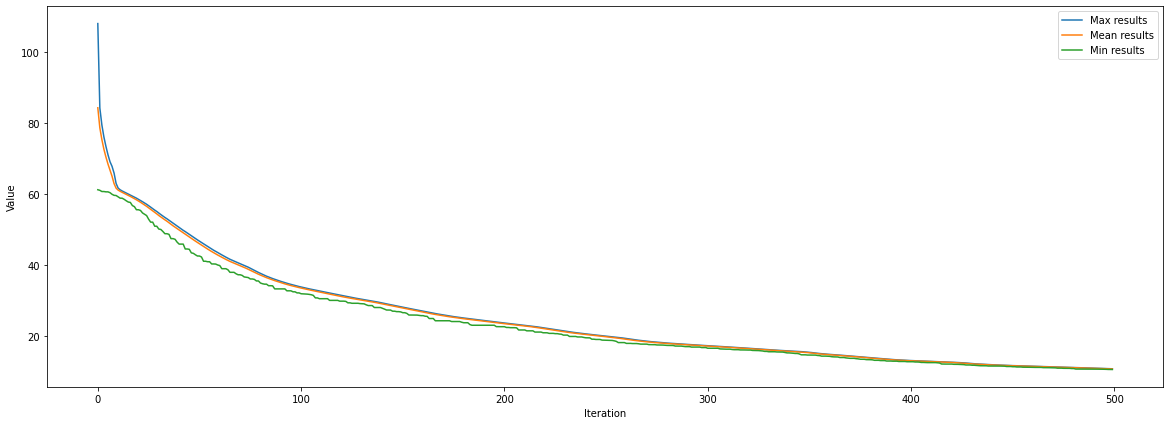

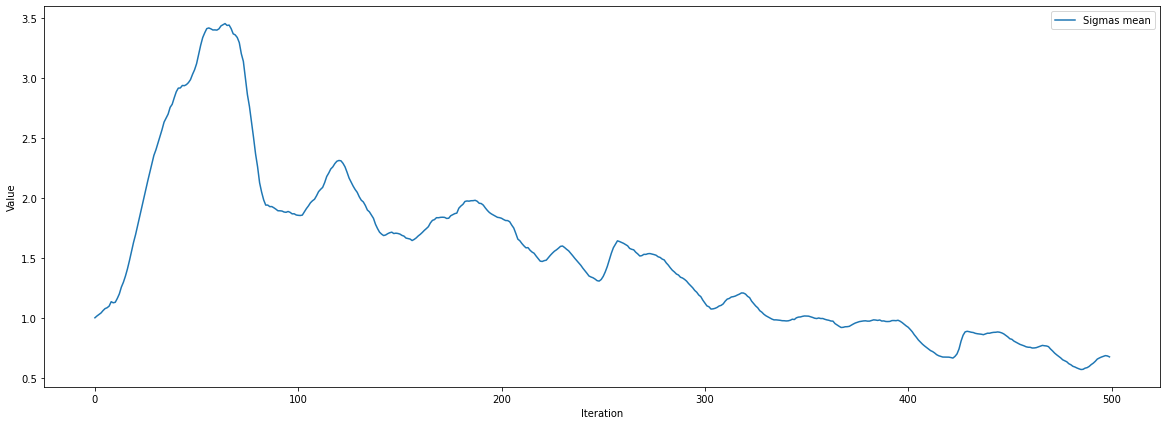

10.480174190833015
[  0.17105811  -9.15525298  11.97434868   2.10348075   8.14110956
  -2.4738749   -7.49778553  -9.13324313   7.44277034  -4.84517677
  -1.72261319 -31.355698     2.92885528   5.2092701    6.20914187
  -3.18667337  -8.68072332 -35.84828508 -14.22010186   0.91238653
  -5.58090944  -8.78530261  14.07512839  -2.11998275  -9.41325431
  10.16748753   1.83376912  -2.0246795    8.56066076   0.65244502
 -15.39327251 -20.78941914  16.82835211  14.74207349  -9.26635632
  -2.97217132   7.81026912  -0.48703502 -44.96489717   2.55970698
  -0.34063637 -39.48291034 -26.12819078   6.17782728   1.74086767
  -9.08672605  -2.87948137  -5.32647137  -2.76197006  74.39255176
  -8.65990578   9.6298731   21.73161647  -3.22876404  76.28783779
 -19.05284791  -4.37697875   4.8507365    0.65873887   3.87899497
 -30.0914244  -19.60736894  -5.54070178   5.67519979   0.97963441
   0.09014323 -14.92309054   1.23635758  39.62203203  15.81123454
   5.01968097 -33.60743577  -8.9408683  -11.49268759  36.

In [34]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(griewank, chromosomes, 2000, 2000, (-100, 100))
    plot_chart(res)
    print(res[5])
    print(res[0])

Mi, lambda


Iter: 0, best result: 6.3487859912838465, mean result: 17.576571834984556
Iter: 100, best result: 1.1888514805532857, mean result: 1.247796992427713
Iter: 200, best result: 0.7334434709436972, mean result: 0.8761018777659026
Iter: 300, best result: 0.2913911789274122, mean result: 0.3029320731684217
Iter: 400, best result: 0.12018232741920998, mean result: 0.12197192221616217


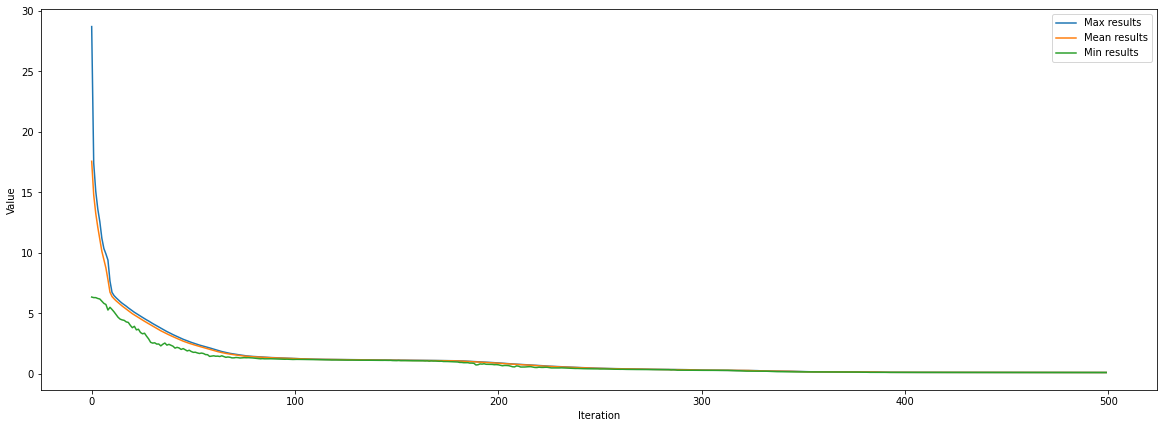

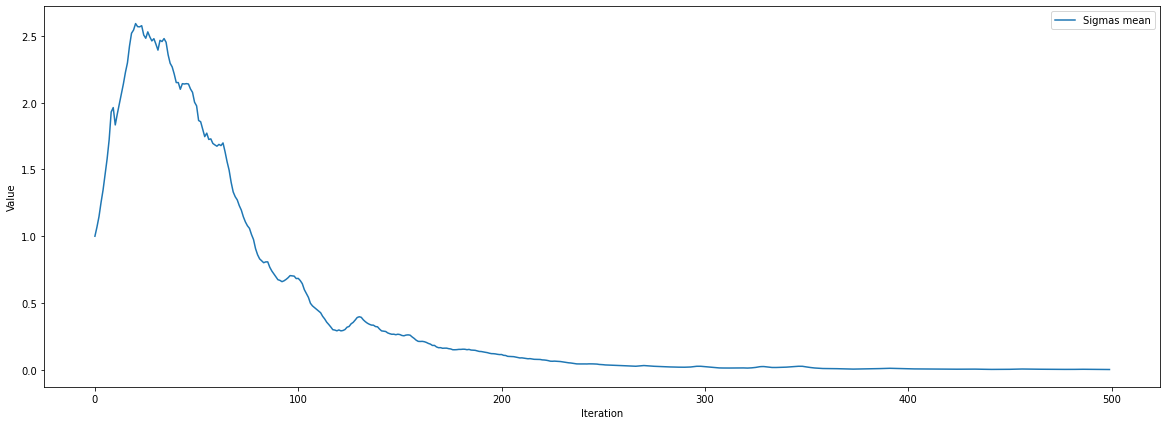

0.110341108118171
[ 1.88469751e+01 -8.83738620e-03  1.05366784e-02 -5.98910883e-02
  1.72958073e-02  1.48157664e-02  1.51359687e-02  4.55097674e-02
 -1.15294382e-02 -4.59170736e-03  3.56440480e-02 -1.42453202e-02
 -3.23270226e-03 -2.99667232e-02 -9.93279227e-03  1.36351822e-03
  1.68305963e-01  2.92618712e-03 -8.67282623e-01 -2.70608986e-02]

Iter: 0, best result: 23.867475906031906, mean result: 42.69156685698889
Iter: 100, best result: 6.442566371443611, mean result: 7.334985694699839
Iter: 200, best result: 2.425901853971701, mean result: 2.7846659311872073
Iter: 300, best result: 1.6225790513404266, mean result: 1.6657958423734627
Iter: 400, best result: 1.3707020904078036, mean result: 1.384281936115694


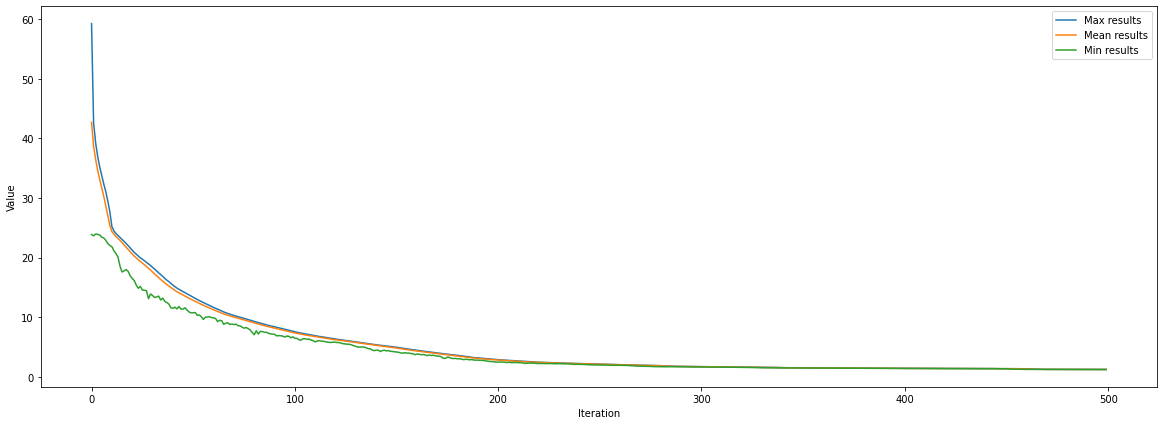

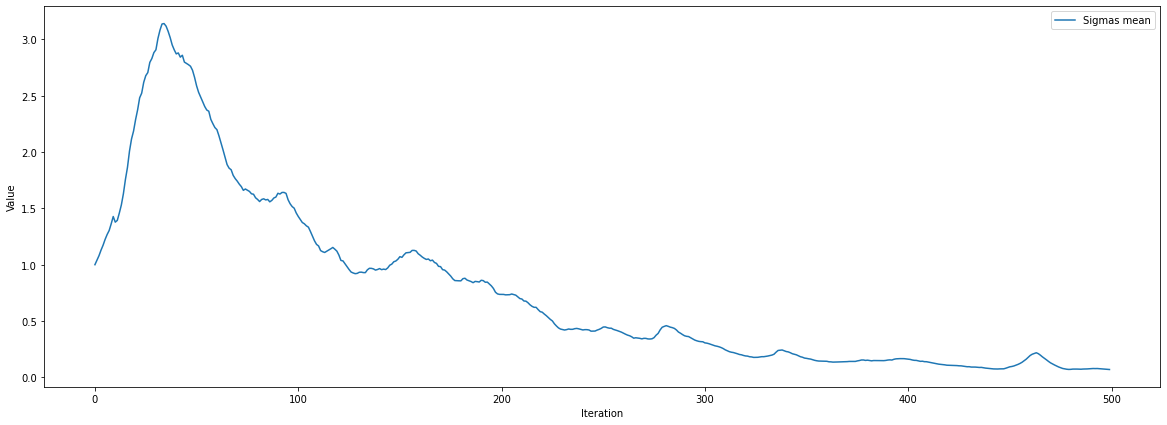

1.196782390626145
[-9.96130953e+00  1.73423959e-01  3.34617493e+00 -1.01913805e+00
 -1.17964567e-01 -2.67752487e+00  1.93045209e+00 -3.72953222e+00
  9.68922917e+00 -1.76006133e+00  1.26594515e+00 -4.55989049e-01
 -5.06666792e-01  1.73660907e+00  2.25252158e+00  1.29253440e+00
 -6.60944473e-01  2.93003727e+00 -3.37779635e-01  1.17471605e+00
 -4.42346319e-01 -1.92943014e-01 -3.85514995e+00 -1.20749345e-02
  1.86492573e+00 -2.43548026e+00 -1.12729415e+01 -2.48062317e+00
  1.40829983e+00  1.32328227e+00  3.58547538e+00  1.31883818e+00
 -1.08240007e+00  4.58010315e-01 -2.81553944e+00 -1.31425350e+00
  1.95317073e+00  1.65546400e+01  2.28065955e+00 -6.79753968e-01
 -3.81434743e-01  8.68876219e-02  8.07332827e-02 -2.12662639e+00
 -9.32690992e-02 -1.08550457e+00 -7.05406611e+00 -9.81499404e-01
  1.26921409e+00  5.34091581e-01]

Iter: 0, best result: 59.54866051570822, mean result: 84.32891828211717
Iter: 100, best result: 28.512371616963886, mean result: 30.661196619910218
Iter: 200, best res

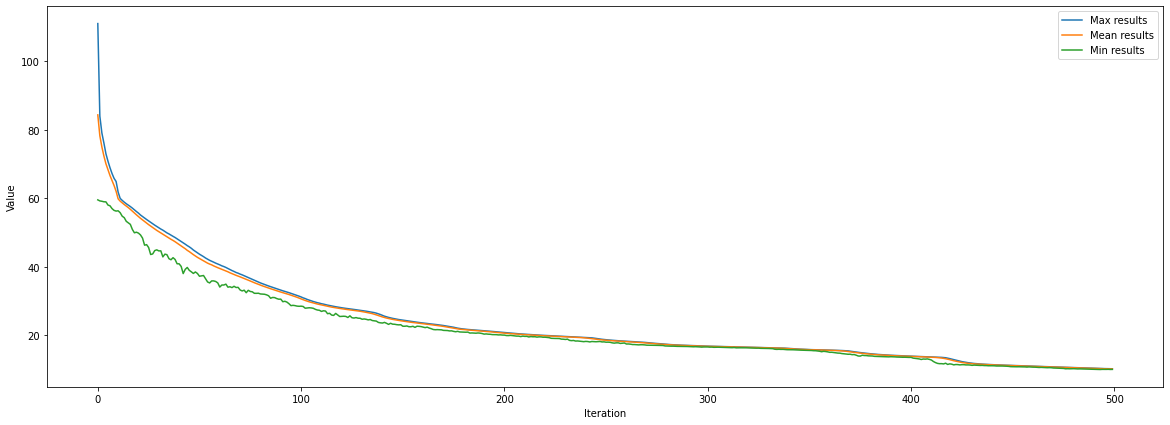

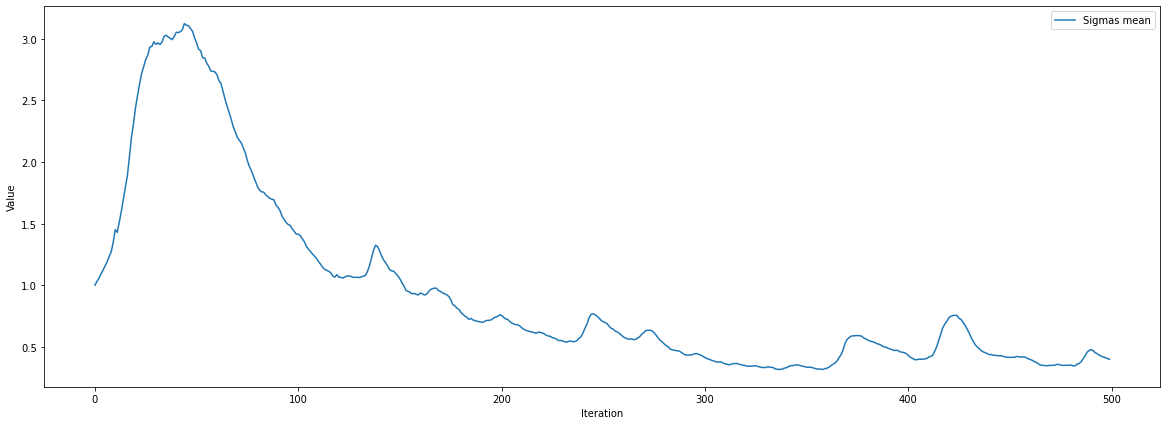

10.076854306376399
[  8.47873643 -37.63350015  -1.44257237  28.56325256   8.28012085
   5.03432091   2.72512096 -24.25955808  -0.23351441   3.61783158
   0.25387824  -0.15928029  15.5971455   -1.62513476 -12.1288938
  -0.39811678   1.74236376  20.13007744  -4.88602284   7.50149922
 -56.24642489   3.25620755 -34.91395647  11.68106306 -12.53728552
  -3.07074903 -10.55926202 -12.50015327  19.77655246 -53.24549139
  -2.13853114   0.40575875  10.38790358 -21.70990248  -1.31639778
   1.84767441  -6.49878813 -20.70074622   7.76934392  -1.12330637
 -10.8335239  -16.82693411   8.02011904  -7.60150401 -10.37203185
  -1.88897624  -6.68589054  -6.92865504  -3.67677657   3.37630505
  45.448874   -22.0004573   11.71600343   5.87234151  -3.50734631
  16.73805146  24.47208026   0.33148449   2.7815025   10.82326023
 -24.06313912  11.53630742   5.41559952 -45.54932719  -1.19940169
  -4.23473187   3.77992604  -3.79823615  -4.778493    24.99509815
  -3.96161851   5.59310475  -9.8829563  -50.69058174 -59.7

In [35]:
for chromosomes in [20, 50, 100]:
    print()
    res=ES_mi_lambda(griewank, chromosomes, 2000, 4000, (-100, 100), is_mi_plus_lambda=False)
    plot_chart(res)
    print(res[5])
    print(res[0])

Rastrigin

In [36]:
def rastrigin(individual):
    return 10 * len(individual) + np.sum(individual * individual - 10 * np.cos(2 * np.pi * individual))
print(rastrigin(np.array([1.0, 4.0, 5.0])))

42.0


Mi + lambda

20
Iter: 0, best result: 190.8492972546732, mean result: 369.90883014869877
Iter: 100, best result: 48.18280820005617, mean result: 54.19507880385819
Iter: 200, best result: 35.23193634140017, mean result: 35.441089581263704
Iter: 300, best result: 34.82869456669334, mean result: 34.83099386819329
Iter: 400, best result: 34.82393400556455, mean result: 34.824029734753786


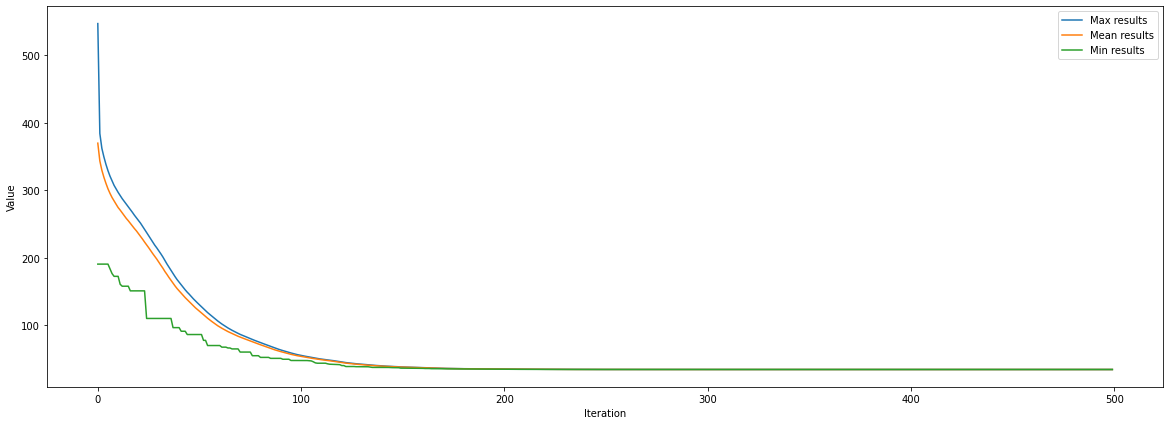

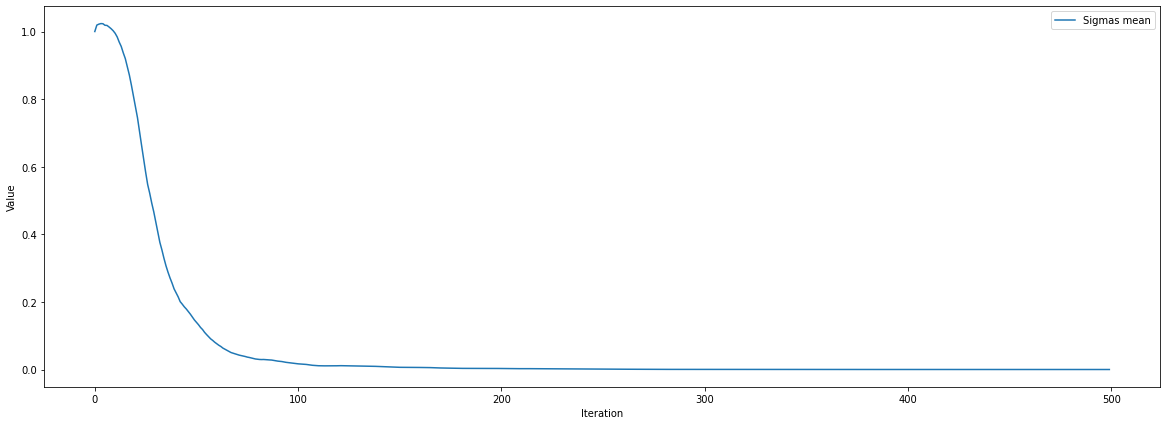

34.82383058317157
[-1.98989125e+00  8.22279863e-05 -1.98989239e+00  1.25113813e-03
 -1.05941419e-05 -9.94995084e-01  9.94987019e-01  8.32146611e-05
 -9.94824405e-01 -2.97388182e-05  1.98988776e+00 -1.98994368e+00
  2.54180148e-05 -2.30065868e-05 -2.56087486e-05 -9.94926636e-01
  2.98486115e+00  1.98987118e+00 -9.94975772e-01  9.94931789e-01]
50
Iter: 0, best result: 723.739912519897, mean result: 923.3085303673975
Iter: 100, best result: 372.94449232897404, mean result: 430.6659850767831
Iter: 200, best result: 257.8806610418418, mean result: 263.2449883341279
Iter: 300, best result: 238.87084114653703, mean result: 240.44651099595328
Iter: 400, best result: 234.53712434381015, mean result: 235.5804544535619


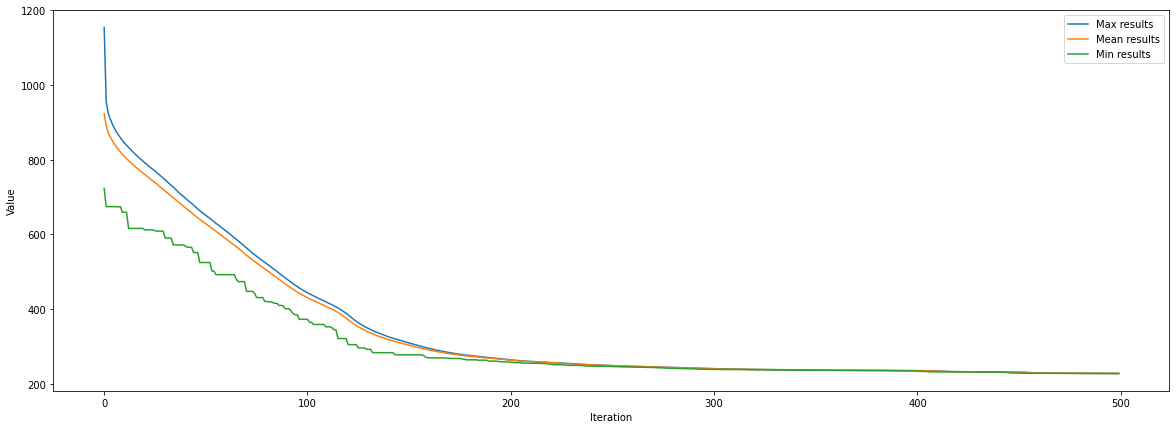

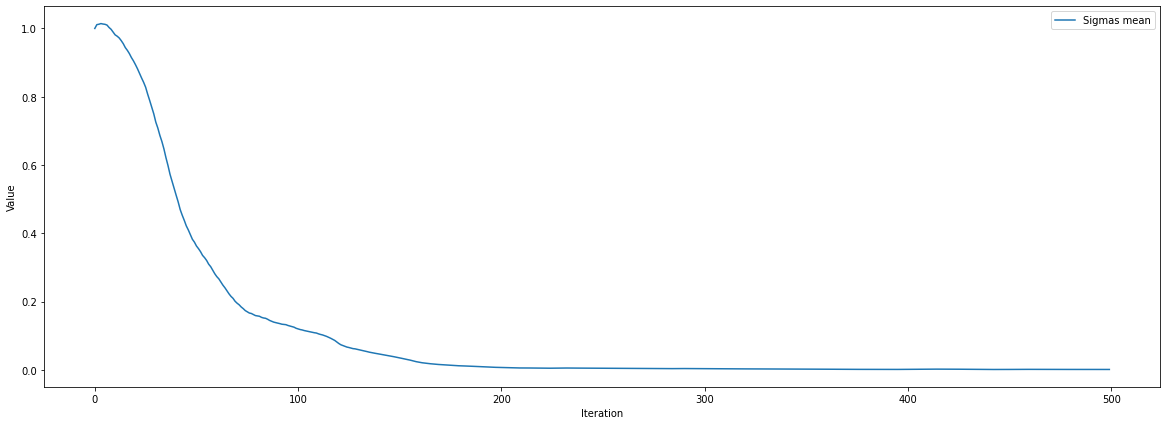

227.89309921455128
[-1.40776366e-02 -1.98178067e+00  9.92540116e-01 -4.97875352e+00
 -1.98957455e+00  6.24085318e-03 -1.98963728e+00  9.37787176e-01
 -2.99368238e+00  2.35592047e-02 -4.03137348e+00 -5.96133385e-03
 -1.99304966e+00  9.86313959e-01  9.04225206e-01  2.98324675e+00
  1.98885782e+00  9.96816189e-01 -1.99163587e+00  1.98871731e+00
  1.00904718e+00 -1.52627095e-02 -4.03520434e-03  9.90153684e-01
 -2.98026812e+00 -3.27063791e-03 -4.51943568e-03 -9.90111701e-01
 -1.99915855e+00 -1.99548969e+00 -9.10542328e-01  3.98137973e+00
  1.98657487e+00 -1.98760099e+00 -2.00094417e+00 -1.03924295e+00
 -9.56895089e-01 -2.99433801e+00 -1.96416448e+00 -1.97964721e+00
 -1.96647083e+00  2.47039004e-03 -4.96972813e+00 -6.71933893e-02
 -1.00666536e+00  9.01349236e-04 -1.42126983e+00  1.79099853e+00
  4.83826005e-03 -9.87054100e-01]
100
Iter: 0, best result: 1552.514220781956, mean result: 1850.8110762533156
Iter: 100, best result: 1289.145154582839, mean result: 1484.0122034209603
Iter: 200, best

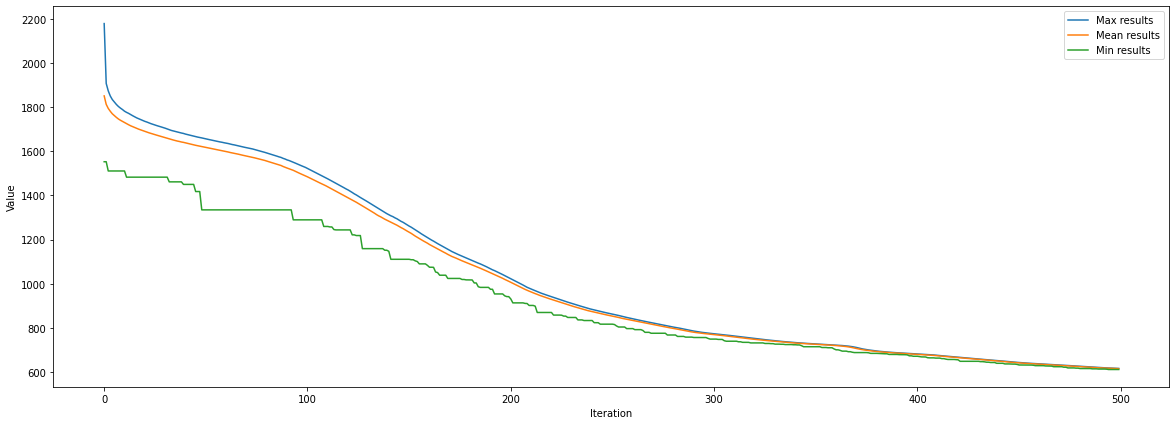

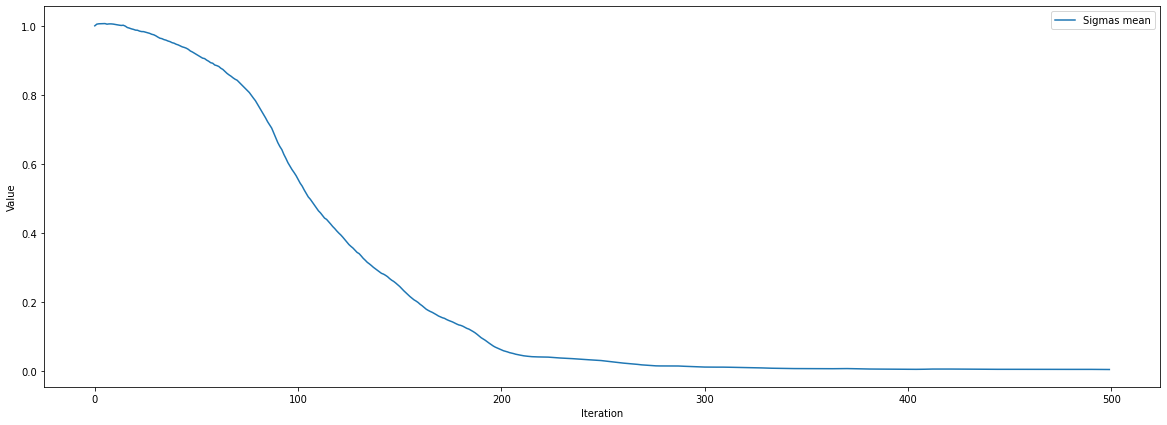

610.9059451158178
[ 9.61890106e-01  9.70803802e-01  5.81227597e-02  2.96386621e+00
  1.13496256e+00 -2.07322842e+00 -9.87201896e-01 -1.88144020e+00
 -7.96703228e-02  7.70760561e-01 -9.75345207e-01 -1.03073524e+00
  1.14649912e-03 -8.35184670e-01  9.82337683e-01 -2.84985749e+00
  9.28622079e-01  1.16740040e-01  1.23698307e+00 -6.78088695e-02
  2.99229561e+00 -5.11186841e+00 -1.96828966e+00 -2.00577427e+00
  8.07218950e-01 -3.16071023e-02 -1.95464096e+00  1.99387299e-02
  2.08478358e+00 -1.96457748e+00  3.02178343e+00  1.36277258e+00
  3.83894228e-01  3.91848308e-03  7.92485430e-01  3.89959149e+00
  9.11383125e-02 -1.99612774e+00  7.77495692e-01 -8.09323783e-03
  2.04291957e+00 -2.58403455e+00 -4.99255482e+00  4.00999506e+00
  9.94861415e-02 -3.22423969e-03 -4.33035189e-02 -1.99443319e+00
 -2.54968235e-02  1.72343774e-02  6.80234042e-02  1.65932251e-01
 -1.96593014e+00 -9.40950982e-01  3.03507980e+00  1.02153016e+00
 -1.06561525e+00 -1.76543735e-01  2.96061093e+00  2.93765975e+00
 -1.985

In [37]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(rastrigin, chromosomes, 2000, 2000, (-5.12, 5.12))
    plot_chart(res)
    print(res[5])
    print(res[0])

20
Iter: 0, best result: 184.8234847784177, mean result: 370.9610838018049
Iter: 100, best result: 48.24241014391998, mean result: 51.78056455362118
Iter: 200, best result: 40.63916794835575, mean result: 41.24598708340407
Iter: 300, best result: 39.195610709516444, mean result: 39.34280736632075
Iter: 400, best result: 38.87239421029568, mean result: 38.876466282909035


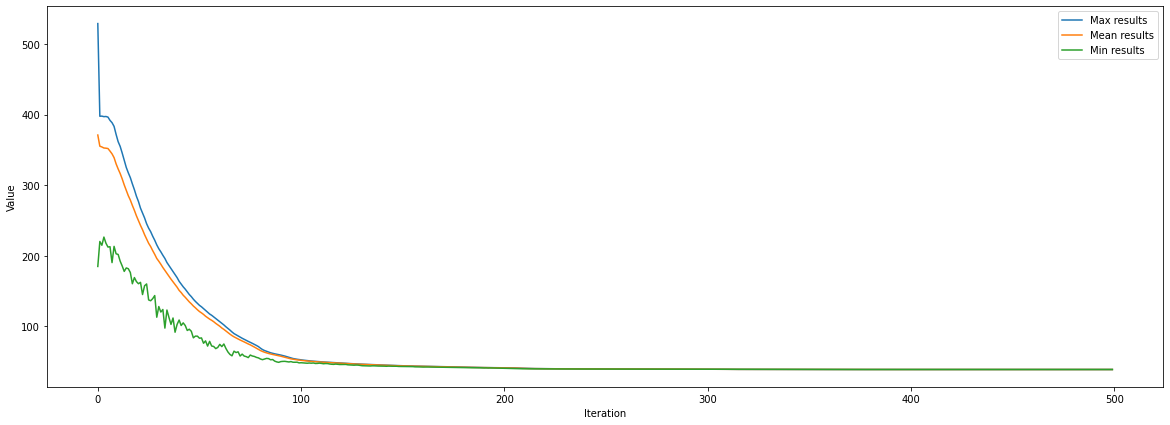

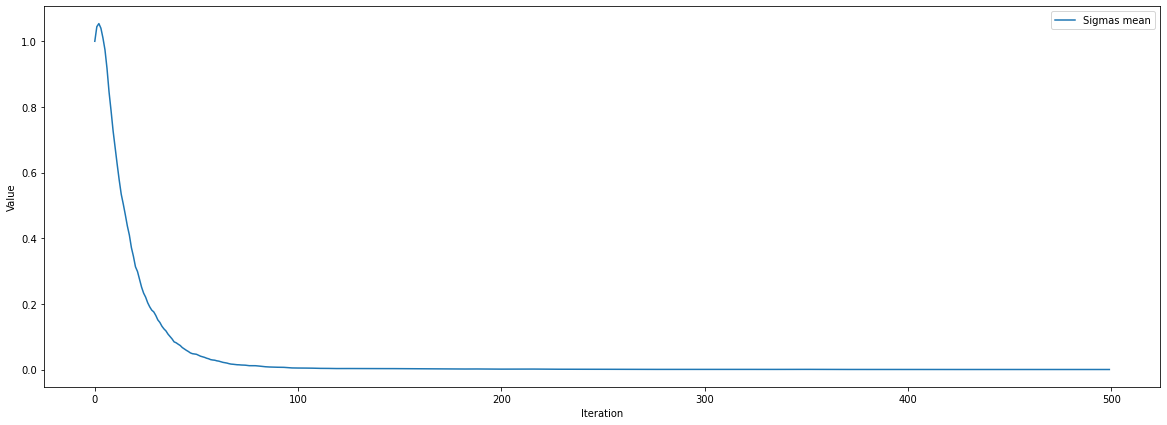

38.86804828915069
[-9.94724356e-01  2.98515400e+00  1.68648225e-02 -1.00135956e+00
  1.27195895e-04 -9.95102734e-01  1.99000469e+00 -1.98979787e+00
  9.94983089e-01  4.32435849e-05 -9.95204877e-01 -2.49124678e-05
  9.95265145e-01  9.94777142e-01 -9.95206276e-01 -1.98991784e+00
 -9.95509088e-01  1.04278346e-04 -2.98439592e+00 -3.57268822e-04]
50
Iter: 0, best result: 715.8518943704019, mean result: 927.3635448915788
Iter: 100, best result: 361.42770234536, mean result: 427.55828111343715
Iter: 200, best result: 249.52308860029112, mean result: 253.77786705263216
Iter: 300, best result: 209.41998696281559, mean result: 211.54150577619626
Iter: 400, best result: 195.36687442316168, mean result: 196.17233290609542


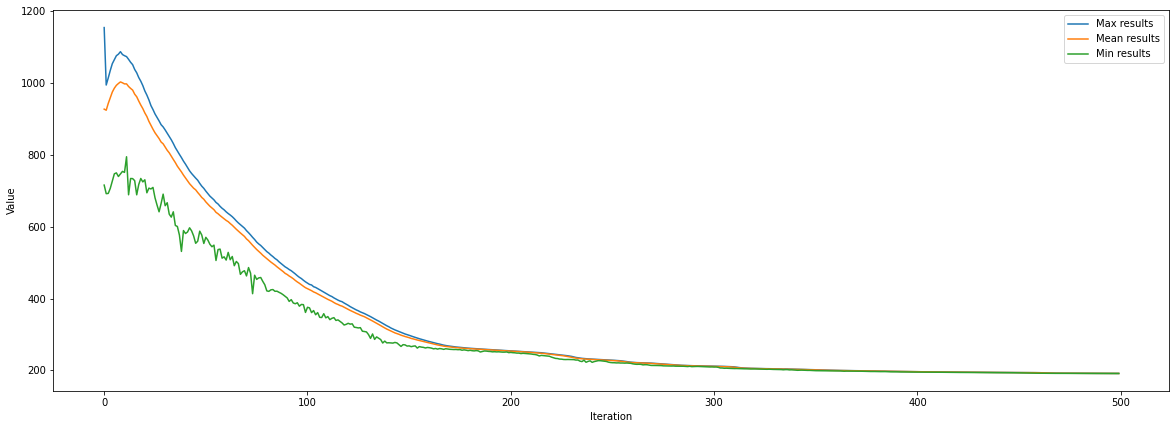

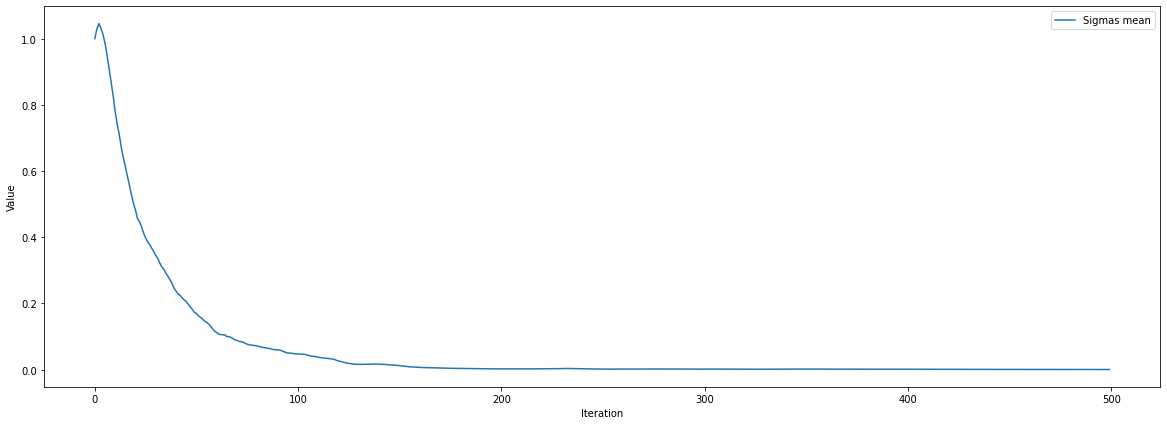

191.42117016321663
[-2.99378722e+00 -8.46145341e-03 -9.81053720e-04 -2.99022687e+00
 -3.19659417e+00  9.92689183e-01 -9.88070517e-01 -1.00396999e+00
  4.96847565e+00 -1.95723905e+00 -1.00111355e+00  9.95726662e-01
  1.44248503e-02 -9.71175409e-01 -9.87115582e-01  9.93694944e-01
  9.97130237e-01  9.52869375e-01  1.00119202e+00 -9.86213785e-01
 -9.17940415e-03  1.41820531e-02  1.99176577e+00  1.00310102e+00
  3.98526074e+00  1.98828627e+00 -9.21663364e-01 -1.07137612e+00
 -1.98996946e+00  1.97700870e+00 -1.09801492e-02  9.85340736e-01
  1.99037749e+00 -9.89069703e-01 -4.36409667e-02 -1.00229406e+00
 -1.02312745e+00 -1.00809190e+00 -2.96292259e+00  9.28163085e-01
 -1.13394231e+00 -1.23950526e+00 -7.41584441e-02  1.90759208e+00
 -9.90124561e-01 -1.98670657e+00 -2.00236463e+00 -1.00087740e+00
  3.97003471e+00  3.04098519e+00]
100
Iter: 0, best result: 1549.518658680604, mean result: 1851.9587202020534
Iter: 100, best result: 1336.0548792910895, mean result: 1481.3243926073424
Iter: 200, bes

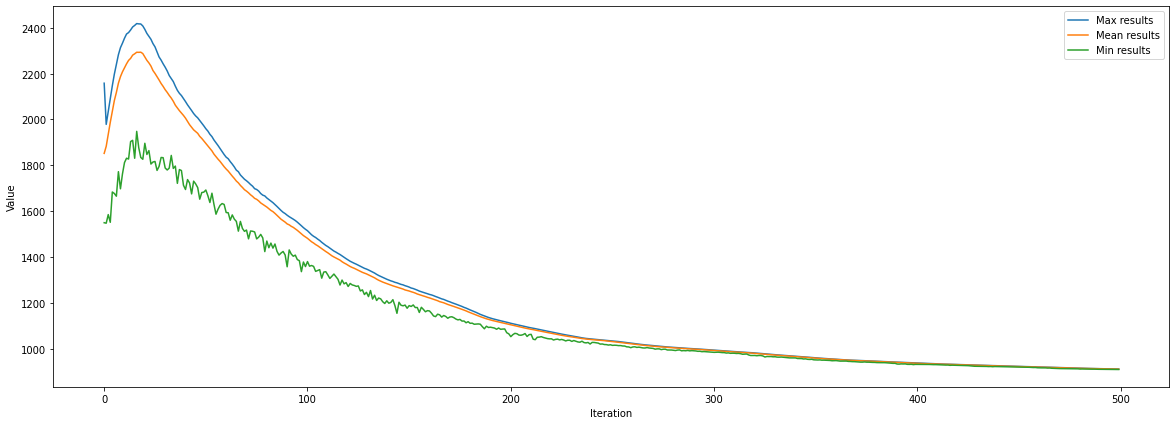

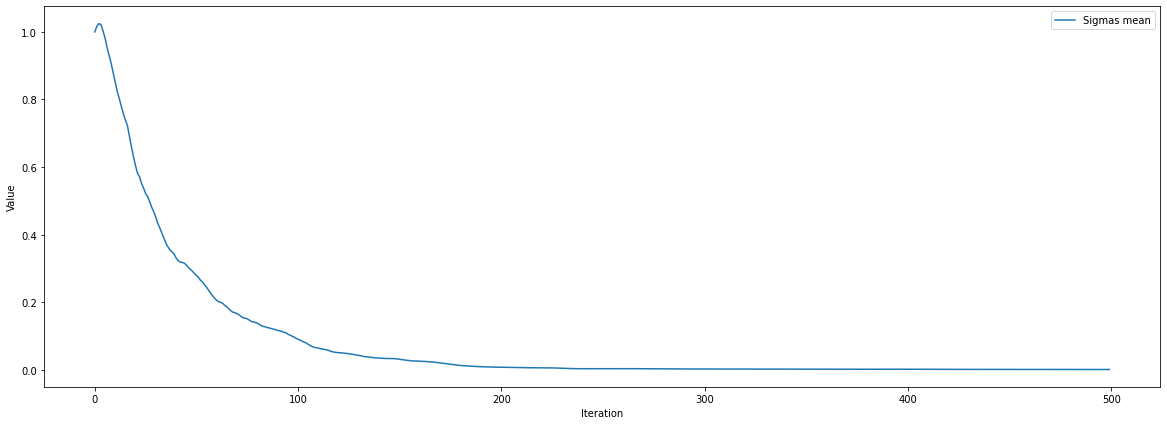

909.2138149610587
[-2.19593828e-03 -4.00462709e+00  1.98312091e+00  4.90349224e+00
  2.01615839e+00  4.99308634e+00  5.74375259e+00 -1.27987405e-02
  2.08939379e+00  1.86048711e+00 -9.76085270e-01  1.92102050e+00
  4.99010569e+00 -9.50249178e-01  9.63167915e-01 -4.96621819e+00
 -2.92528340e+00  2.95018360e+00  8.95799884e-03 -1.89950605e+00
  4.51399969e-01 -2.99991026e+00  2.23917711e-03 -2.02581091e+00
 -2.06203868e+00  3.05410246e+00  1.54341588e-02 -1.02871158e+00
  5.02836172e+00 -3.84694316e+00  1.95682916e+00  9.65468403e-01
  1.00943288e+00  1.12832680e+00 -8.76161218e-01 -1.18491159e+00
  8.49921172e-01 -1.29540302e-01  3.90244289e+00  2.48005574e-02
 -9.53161816e-01 -1.00347386e+00  1.92560013e+00  1.89653449e+00
 -3.97362148e+00  6.11122293e+00 -1.36894948e-02 -1.98169992e+00
 -1.28121990e-01 -9.68065135e-01  1.96972484e+00 -1.03096474e+00
 -6.96760632e+00  5.42964066e+00  4.93790257e+00 -9.71467364e-01
  1.98824909e+00 -4.20002794e-01  2.03153780e+00 -3.95930266e+00
 -8.504

In [38]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(rastrigin, chromosomes, 2000, 4000, (-5.12, 5.12), is_mi_plus_lambda=False)
    plot_chart(res)
    print(res[5])
    print(res[0])

Rosenbrock

In [39]:
def rosenbrock(individual):
    return np.sum(100 * (individual[:len(individual) -1] ** 2 - individual[1:]) ** 2 + (1 - individual[:len(individual) -1]) ** 2)
rosenbrock(np.array([0.0, 0.0, 0.0]))

2.0

Mi + lambda

20
Iter: 0, best result: 185022.44329355576, mean result: 2388054.255857336
Iter: 100, best result: 329.4567691085202, mean result: 491.2191543565339
Iter: 200, best result: 93.48269549207328, mean result: 116.25302686723697
Iter: 300, best result: 55.48595531299837, mean result: 64.75964260181304
Iter: 400, best result: 25.86335574846176, mean result: 27.39185695616249


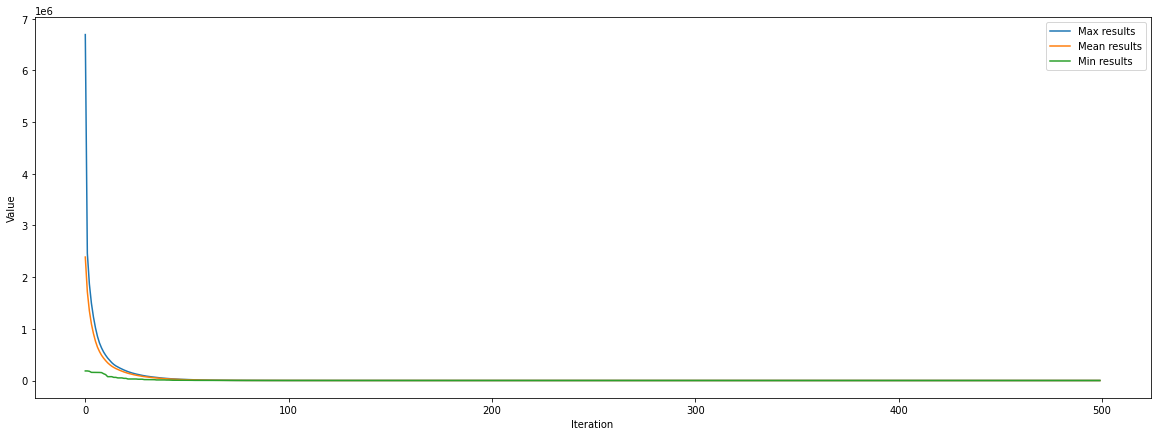

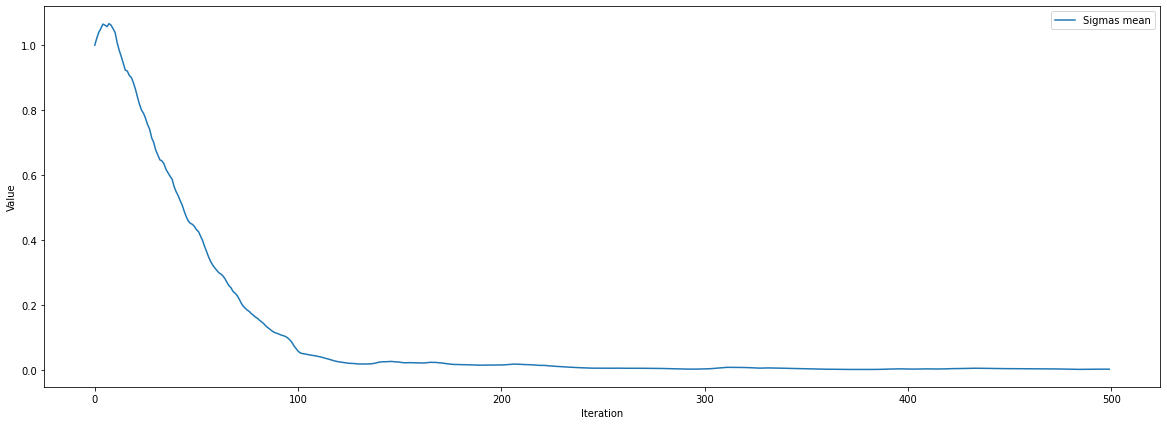

11.054188542770465
[-0.99969847  1.00332513  0.99411817  0.97651675  0.94561538  0.95514298
  0.96541287  0.96013307  0.97575397  0.96772129  0.93728391  0.8659098
  0.92224798  0.94420517  0.9978349   1.04776523  1.09056833  1.20797173
  1.51419839  2.29350802]
50
Iter: 0, best result: 1858281.016235398, mean result: 6286334.777677289
Iter: 100, best result: 203353.37236100365, mean result: 244166.46401814246
Iter: 200, best result: 32462.33789838465, mean result: 39929.013293210446
Iter: 300, best result: 11414.443793184262, mean result: 12841.408048877225
Iter: 400, best result: 5120.354278363604, mean result: 5735.391340135327


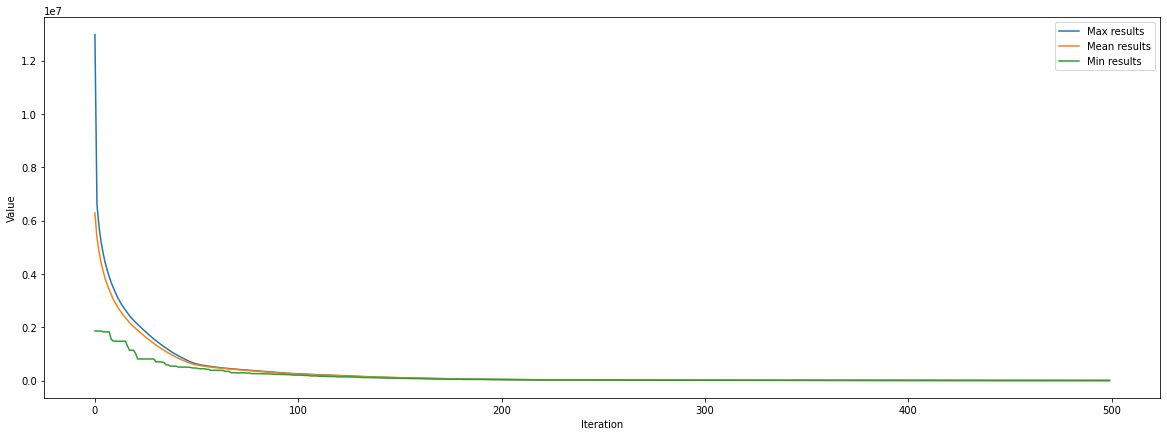

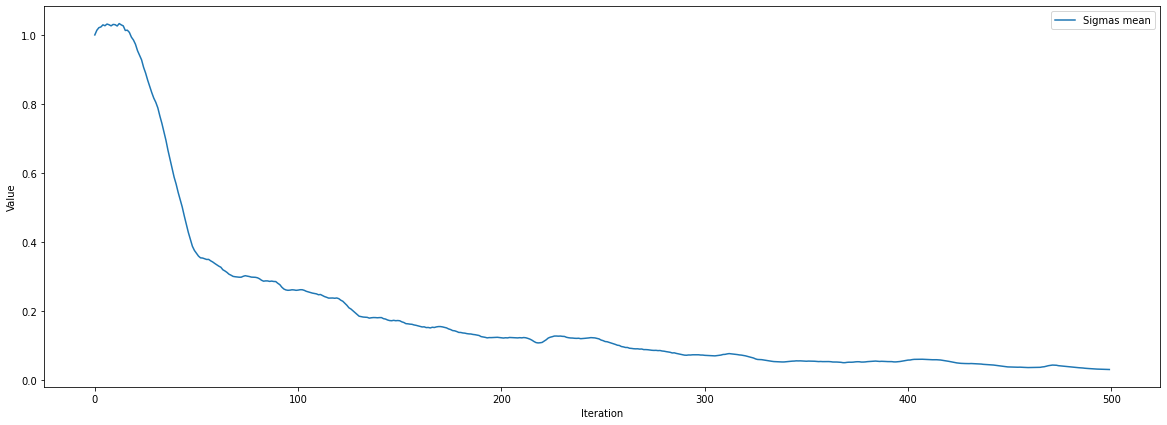

2536.1152069637556
[ 1.20240026e+00  9.57320302e-01  1.00250525e+00  7.62447964e-01
 -3.59429358e-01  8.81603322e-01  9.07125975e-01  1.43559548e+00
  1.00546276e+00  7.80325442e-01  5.70233428e-01  5.48556891e-02
  5.44317523e-01  7.81836163e-01  1.39426873e+00  1.78777540e+00
  1.35204254e+00  1.28750995e+00  1.30725717e+00  1.01429289e+00
  2.84719159e-01  1.55686465e-01  5.16884586e-02 -7.55906882e-01
  3.66563344e-01  2.15196450e-01  3.36217463e-01 -9.05259882e-02
  3.14013817e-01 -1.84452332e-01 -1.72505850e-01 -5.18559610e-01
  3.40301573e-01 -1.60939813e+00  8.12834839e-01 -7.86071414e-01
  4.33237361e-01 -6.10926972e-01  4.24069799e-04 -7.51389905e-01
  8.28589038e-01  9.41952647e-01  1.19137550e+00  1.52907770e+00
  1.30935892e+00  1.32088504e+00  1.22227346e+00 -2.06417349e-01
  1.55417614e-01 -2.19651942e-01]
100
Iter: 0, best result: 5985646.21538168, mean result: 12641105.181908809
Iter: 100, best result: 1665674.7074014132, mean result: 1950675.8000662548
Iter: 200, best

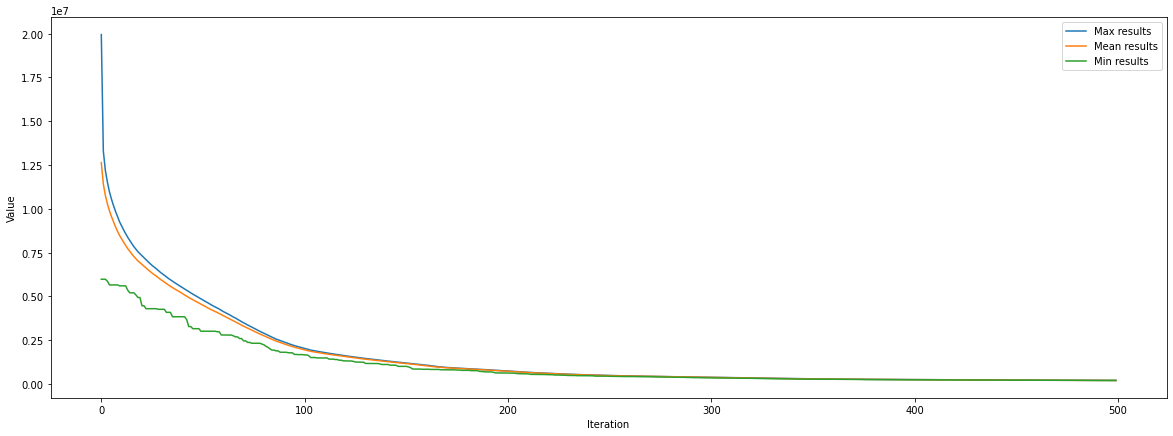

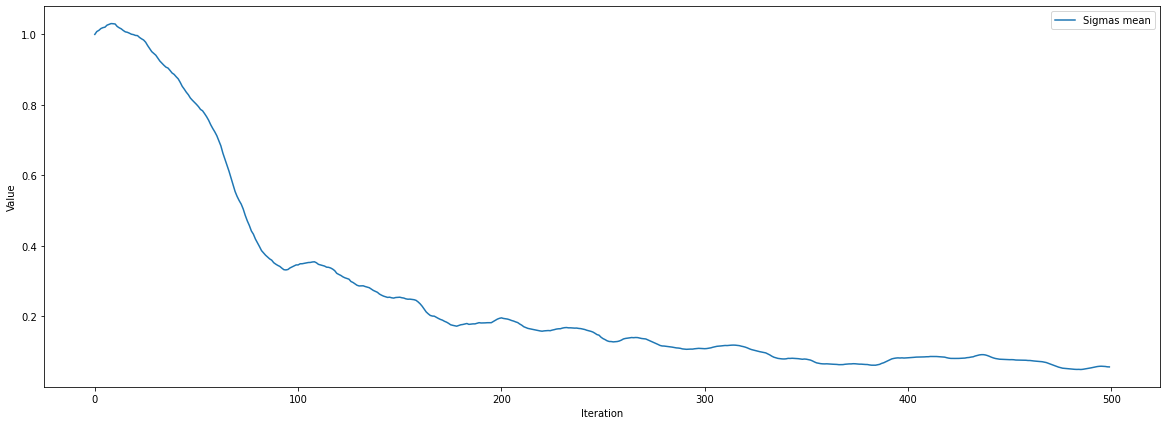

205398.03487880394
[ 0.44776935 -1.64458077  0.2351604   0.55540309 -2.25003953  0.68542891
 -2.44523011  1.22569705  0.91145908  1.48467438  2.35361086  0.59772142
 -4.12390591  1.85493843  1.07597006  0.93216102  1.14332751 -0.55755784
  0.84763123  0.8759206  -0.22561803 -0.68150964 -0.29208302 -1.98523534
  1.32826054  1.22960713 -3.0411083   2.05241666  1.95580811  1.89887297
  2.31049286 -1.29548806  3.09064976  0.91103517 -0.81643208 -0.34579192
 -1.35860664 -1.09031558 -0.20716938 -0.89482706  1.01229005 -1.52958493
  1.93660675 -0.21518665 -0.60502975 -2.58974612  5.80843725  2.34666286
 -1.37704346 -0.66594089  1.75054187  1.81276903  2.77202335  1.29789511
  0.00996488 -1.23141324 -1.31807787  2.10109938  0.19379558  0.29181715
  2.73127157  2.33286697 -0.62955663 -2.25346514  0.48968564 -1.03088006
  1.04791283  0.12376365  1.51076147  1.02753678  0.95931873 -2.60497683
  1.84358884  1.68538808  1.3283608  -1.01209785  1.96425409  1.74897589
  1.59888167 -0.0758037   2.3864

In [40]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(rosenbrock, chromosomes, 2000, 2000, (-5, 10))
    plot_chart(res)
    print(res[5])
    print(res[0])

20
Iter: 0, best result: 261237.01050473886, mean result: 2428311.228661691
Iter: 100, best result: 1236.7389616428102, mean result: 1703.7459293421043
Iter: 200, best result: 132.3260016363512, mean result: 163.29870818086738
Iter: 300, best result: 45.40618387427468, mean result: 49.0817307283125
Iter: 400, best result: 19.54029313114633, mean result: 38.40711858566941


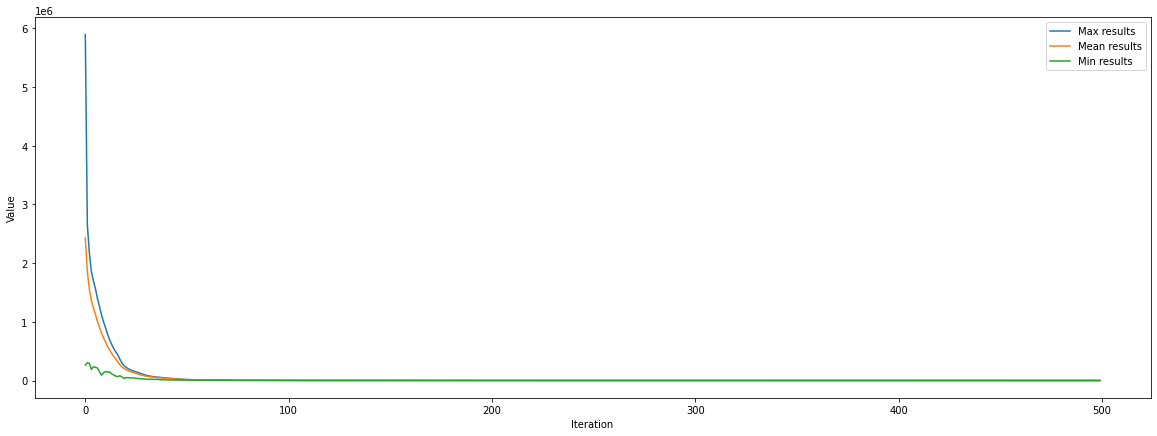

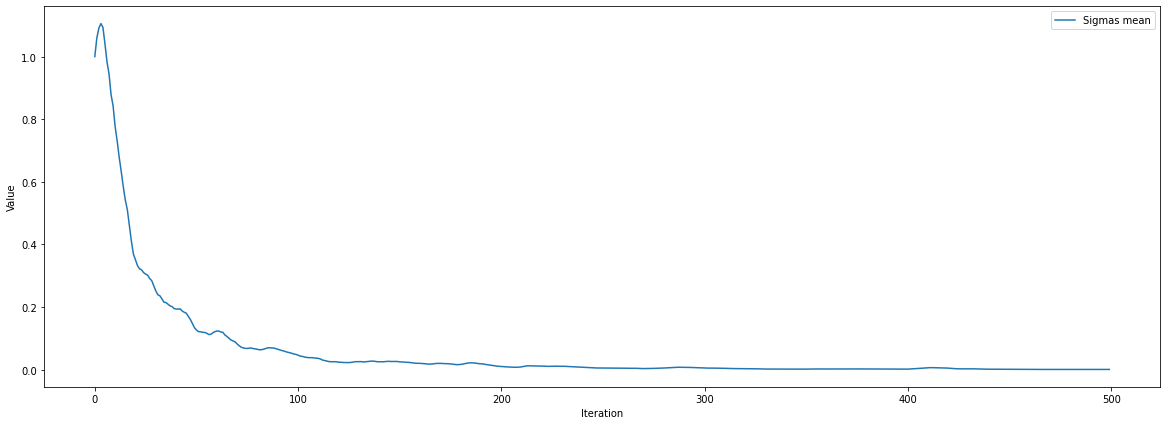

9.88699782583768
[ 1.00605797  1.01443784  1.02301042  1.01106848  0.98516931  0.96345308
  0.92167183  0.83889041  0.68673961  0.48400057  0.25462973  0.07676249
  0.01600068  0.00211781  0.0174666  -0.0746748   0.02208928  0.00546924
 -0.00125301 -0.01627718]
50
Iter: 0, best result: 1530994.432068165, mean result: 6243317.14016333
Iter: 100, best result: 505819.9223014495, mean result: 561075.0896817386
Iter: 200, best result: 174446.83301538942, mean result: 194255.0907158346
Iter: 300, best result: 127710.28839099541, mean result: 131738.65768897953
Iter: 400, best result: 117565.9542158146, mean result: 119406.53655216657


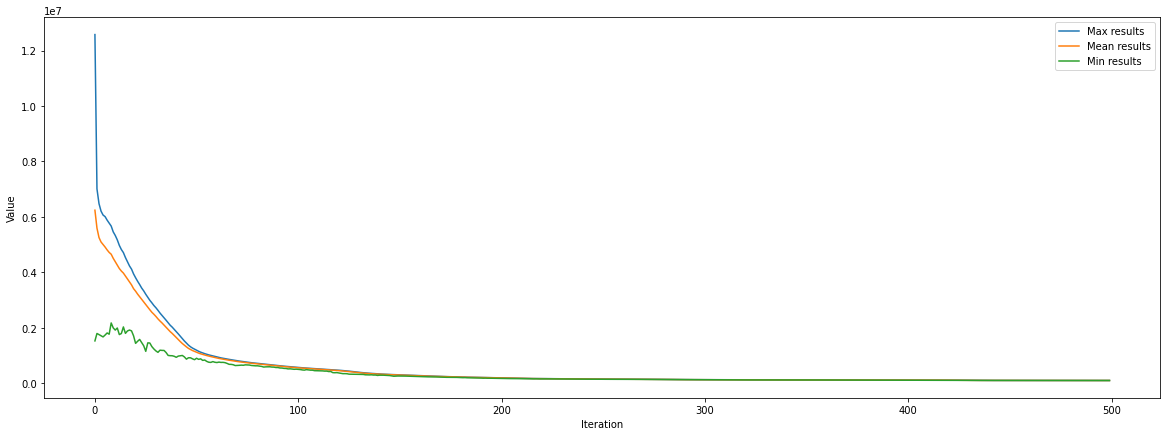

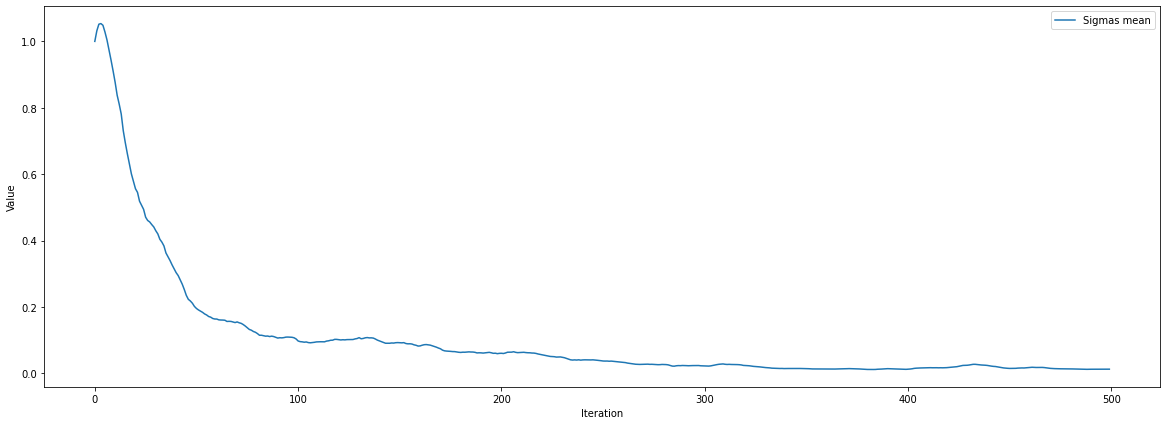

103051.88033233385
[-1.34196289  2.04895192  0.41176834 -1.59526565  0.49857081  0.14890148
 -1.53489111  1.40709898  1.54440867  3.11351513  2.19344213  2.2344558
  1.15057605  2.22363702  5.19762438  2.61290756  1.86297084  1.89915844
  0.35851533 -0.4570962  -1.16301768  1.41537701  1.27239898  0.67789713
 -2.10619502  1.11988294  0.44278402  0.92070556  1.2772429   1.34166163
  1.64581143  3.08039753  1.73978411  0.04351904 -0.23815133  0.02380939
  1.83737925  3.8247382   0.89453762  0.33928817  0.36840763  0.2500666
 -0.01274637  0.76255556  0.96400807  1.06645371  0.47107132 -1.12392674
  1.68043161  0.67551441]
100
Iter: 0, best result: 6362053.47855083, mean result: 12573946.397447776
Iter: 100, best result: 2315198.343095649, mean result: 2767169.278930876
Iter: 200, best result: 1159360.0630353496, mean result: 1274545.4741767826
Iter: 300, best result: 642508.4280856423, mean result: 686595.6046354823
Iter: 400, best result: 319579.1169912246, mean result: 335142.2762740208

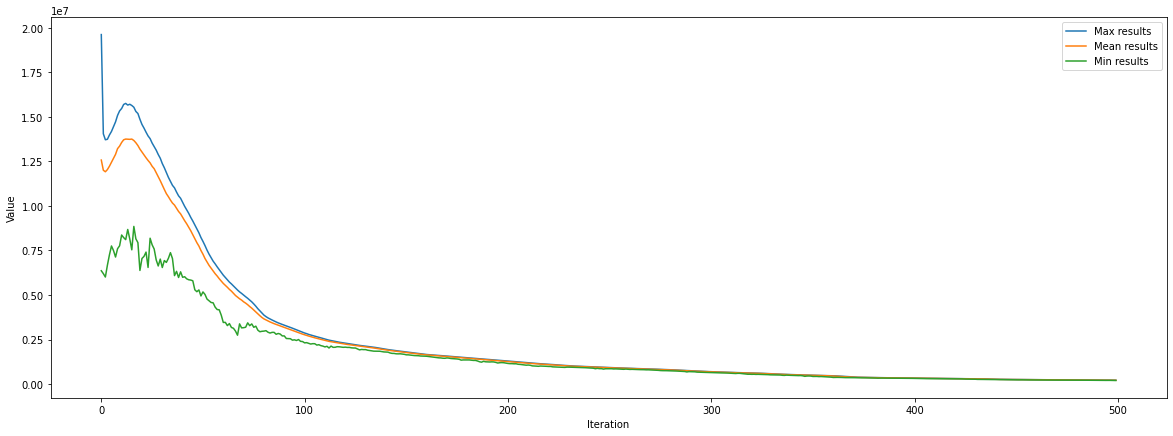

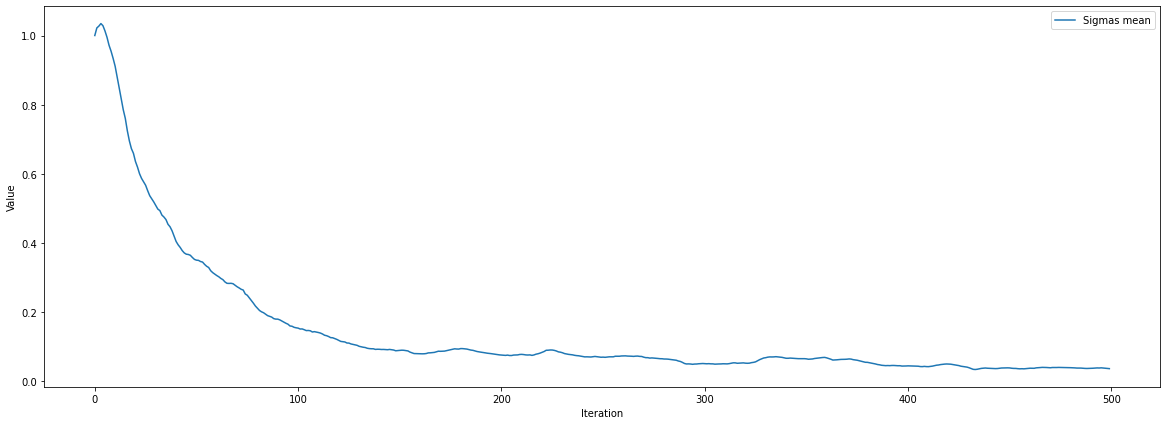

202309.0504394198
[-0.94680653 -3.40625716  0.82690408 -0.1885702  -3.20854374  1.99379787
  3.35512827  2.53512903  1.39726423 -1.03570433 -0.39362687  0.39986429
 -2.77517074  1.28175428 -1.12771062  0.61084004 -0.98785598 -1.06437233
  1.13430088  0.76501806 -2.06552329 -0.7863986   0.37951016 -1.41999471
  1.5193835   1.22604671 -1.12063952  0.47182825 -1.70479324 -0.05723485
 -1.64691305 -2.76177619  1.02527562 -1.7997759  -2.16065677  1.39145537
 -2.63495015  0.63484612  2.18521535  1.4500163   2.56567552  0.90686211
 -1.51887683  3.05760476 -0.93522984  3.84095708  0.76701608  1.52113097
 -0.53546104  1.23059117  1.28359218  3.68651702  1.19955369  3.82749579
  1.9348408  -1.18748353 -0.84835073 -0.20181474  2.05863077 -2.20320623
 -1.0972653  -0.04767562 -2.18590034  1.58503503  1.45221903 -0.55819788
 -0.01182043  1.50738659 -1.59525282  3.30820986  1.01483185 -1.60814182
 -0.66234885  1.92556098  2.04066596  1.09299722 -3.134677    2.90585823
  1.50761615  2.4341139   3.39379

In [41]:
for chromosomes in [20, 50, 100]:
    print(chromosomes)
    res=ES_mi_lambda(rosenbrock, chromosomes, 2000, 4000, (-5, 10), is_mi_plus_lambda=False)
    plot_chart(res)
    print(res[5])
    print(res[0])

## Zad.2

In [54]:
def constrained_random_population(chromosome_length, mi, restrictions, x_bounds, s_bounds):
    res=np.full((mi, 2, chromosome_length), 0.0)
    for num_of_child in range(mi):
        candidate=np.random.uniform(x_bounds[0], x_bounds[1], chromosome_length)
        while(not restrictions(candidate)):
            candidate=np.random.uniform(x_bounds[0], x_bounds[1], chromosome_length)
        res[num_of_child, 0, :]=candidate
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], chromosome_length)
    return res

In [67]:
def constrained_mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length, restrictions, x_bounds):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, chromosome_length) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        tmp = np.array(P_children[i, 0, :])
        epsilons_for_first_chromosome = np.random.normal(0, 1, chromosome_length) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
        if(not restrictions(P_children[i, 0, :]) or np.any(P_children[i, 0, :] > x_bounds[1]) \
            or np.any(P_children[i, 0, :] < x_bounds[0])):
            P_children[i, 0, :] = tmp
    return P_children

In [68]:
def constrained_ES_mi_lambda(objective_function, chromosome_length, mi_param, lambda_param, restrictions, x_bounds, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000, looking_for_max=False):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*chromosome_length)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(chromosome_length))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population(chromosome_length, mi_param, restrictions, x_bounds, s_bounds)
    evaluation_result=eval_population(objective_function, P[:, 0, :])
    for i in range(iterations_number):
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length, restrictions, x_bounds)
        children_evaluation_result=eval_population(objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda, looking_for_max)
    best_index = evaluation_result.argmax() if looking_for_max else evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

G3

In [32]:
def G3_objective_function(individual):
    n=len(individual)
    return np.sqrt(n) ** n * np.prod(individual)

In [33]:
def constrained_random_population_for_g3(chromosome_len, mi, s_bounds):
    res=np.full((mi, 2, chromosome_len), 0.0)
    for num_of_child in range(mi):
        candidate=np.random.uniform(0, 1, chromosome_len)
        res[num_of_child, 0, :]=candidate / np.sqrt(np.sum(candidate ** 2))
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], )
    return res

In [34]:
def constrained_mutation_for_g3(P_children, chromosome_length, tau_param, tau_zero_param, lambda_param):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, chromosome_length) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        epsilons_for_first_chromosome = np.random.normal(0, 1, chromosome_length) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
        P_children[i, 0, :] = P_children[i, 0, :] / np.sqrt(np.sum(P_children[i, 0, :] ** 2))
    return P_children

In [35]:
def constrained_ES_mi_lambda_for_g3(chromosome_length, mi_param, lambda_param, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000, looking_for_max=True):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*chromosome_length)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(chromosome_length))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population_for_g3(chromosome_length, mi_param, s_bounds)
    evaluation_result=eval_population(G3_objective_function, P[:, 0, :])
    for i in range(iterations_number):
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation_for_g3(P_children, chromosome_length, tau_param, tau_zero_param, lambda_param)
        children_evaluation_result=eval_population(G3_objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda, looking_for_max)
    best_index = evaluation_result.argmax() if looking_for_max else evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

Mi + lambda

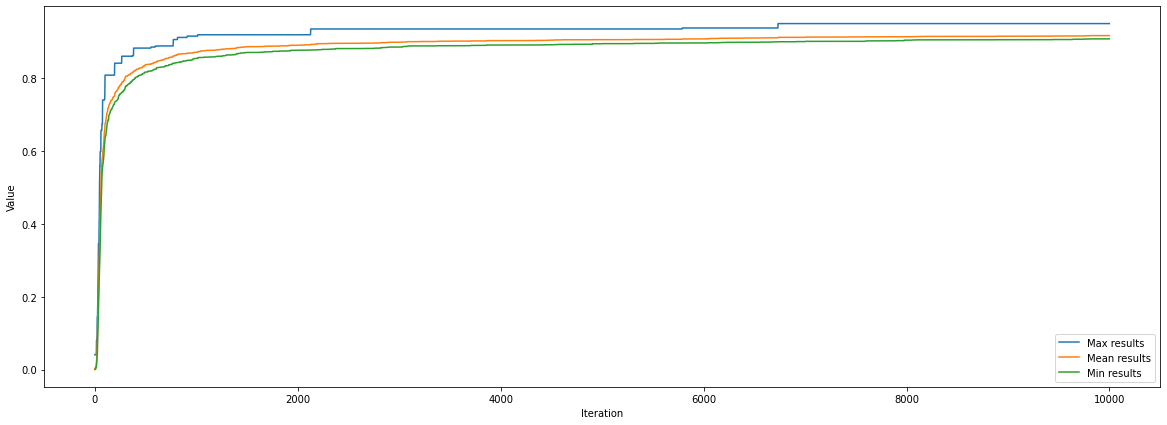

[0.22545911 0.21368931 0.23851456 0.22144526 0.22815747 0.233965
 0.23842788 0.23277981 0.22839353 0.2075402  0.20492234 0.20932596
 0.21061595 0.21176847 0.21436595 0.24080129 0.22744063 0.21565549
 0.22764234 0.23558545]


In [38]:
res=constrained_ES_mi_lambda_for_g3(20, 50, 50)
plot_chart(res)
print(res[0])

Mi, lambda

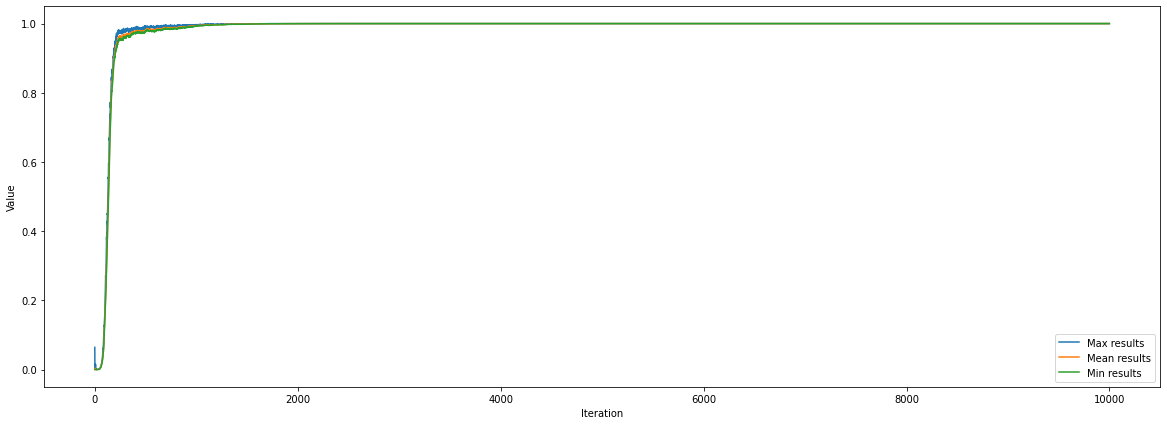

[0.2236068  0.2236068  0.2236068  0.2236068  0.22360679 0.2236068
 0.2236068  0.2236068  0.2236068  0.2236068  0.2236068  0.2236068
 0.2236068  0.2236068  0.2236068  0.22360679 0.2236068  0.22360679
 0.2236068  0.22360679]


In [39]:
res=constrained_ES_mi_lambda_for_g3(20, 50, 100, is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G6

In [40]:
def G6_restrictions(individual):
    return (individual[0] - 5) ** 2 +  (individual[1] - 5) ** 2 >= 100 and (individual[0] - 6) ** 2 +  (individual[1] - 5) ** 2 <= 82.81  

In [41]:
def G6_objective_function(individual):
    return (individual[0] - 10) ** 3 + (individual[1] - 20) ** 3

In [42]:
def constrained_random_population_for_g6(mi, s_bounds):
    res=np.full((mi, 2, 2), 0.0)
    for num_of_child in range(mi):
        candidate=np.concatenate((np.random.uniform(13, 15.1, 1), np.random.uniform(0, 14.1, 1)))
        while(not G6_restrictions(candidate)):
            candidate=np.concatenate((np.random.uniform(13, 15.1, 1), np.random.uniform(0, 14.1, 1)))
        res[num_of_child, 0, :]=candidate
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], 2)
    return res
constrained_random_population_for_g6(10, (0, 1))

array([[[1.50211004e+01, 4.12463008e+00],
        [6.16049135e-01, 8.43885334e-01]],

       [[1.50338133e+01, 4.30345108e+00],
        [5.63970972e-01, 7.37712846e-01]],

       [[1.48011687e+01, 2.91154480e+00],
        [1.19524972e-02, 3.55331489e-01]],

       [[1.46187021e+01, 7.77343618e+00],
        [8.80492846e-01, 4.63237127e-01]],

       [[1.49432865e+01, 6.36630783e+00],
        [2.61708105e-01, 6.73129285e-01]],

       [[1.49594456e+01, 6.09488546e+00],
        [7.80659099e-01, 7.21582871e-01]],

       [[1.50414133e+01, 5.56600526e+00],
        [4.03575639e-01, 4.50536881e-02]],

       [[1.49339741e+01, 6.16927757e+00],
        [4.75994994e-01, 9.08433899e-01]],

       [[1.49603318e+01, 3.78263848e+00],
        [7.43594358e-01, 7.17273412e-01]],

       [[1.44261793e+01, 8.42051714e+00],
        [8.06723237e-01, 2.39022912e-01]]])

In [43]:
def constrained_mutation_for_g6(P_children, tau_param, tau_zero_param, lambda_param):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, 2) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        tmp = np.array(P_children[i, 0, :])
        epsilons_for_first_chromosome = np.random.normal(0, 1, 2) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
        if not G6_restrictions(P_children[i, 0, :]) or np.any(P_children[i, 0, :] > 100) \
            or P_children[i, 0, 0] < 13 or P_children[i, 0, 1] < 0:
            P_children[i, 0, :] = tmp
    return P_children

In [46]:
def constrained_ES_mi_lambda_for_g6(mi_param, lambda_param, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*2)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(2))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population_for_g6(mi_param, s_bounds)
    evaluation_result=eval_population(G6_objective_function, P[:, 0, :])
    for i in range(iterations_number):
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation_for_g6(P_children, tau_param, tau_zero_param, lambda_param)
        children_evaluation_result=eval_population(G6_objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda=is_mi_plus_lambda)
    best_index = evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

Mi + lambda

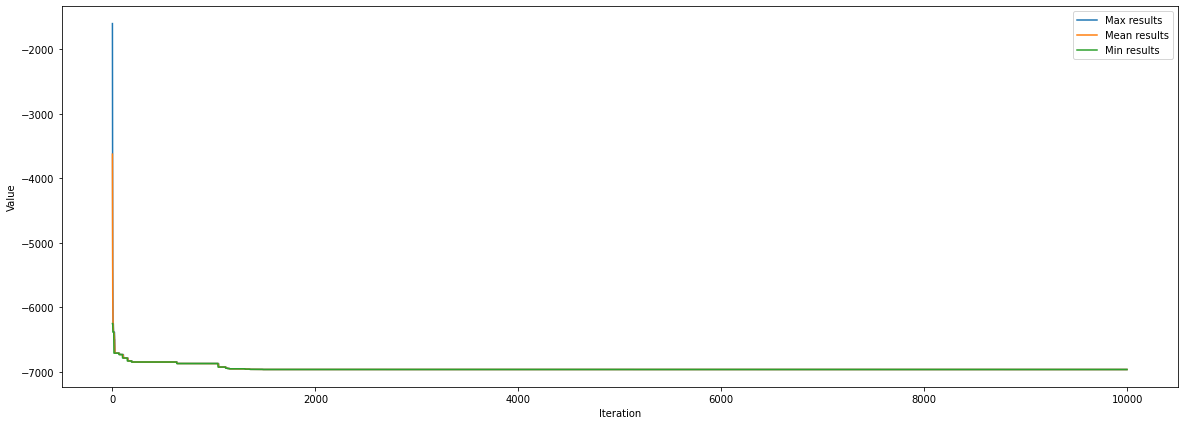

[14.09500795  0.84297665]


In [47]:
res=constrained_ES_mi_lambda_for_g6(50, 50)
plot_chart(res)
print(res[0])

Mi, lambda

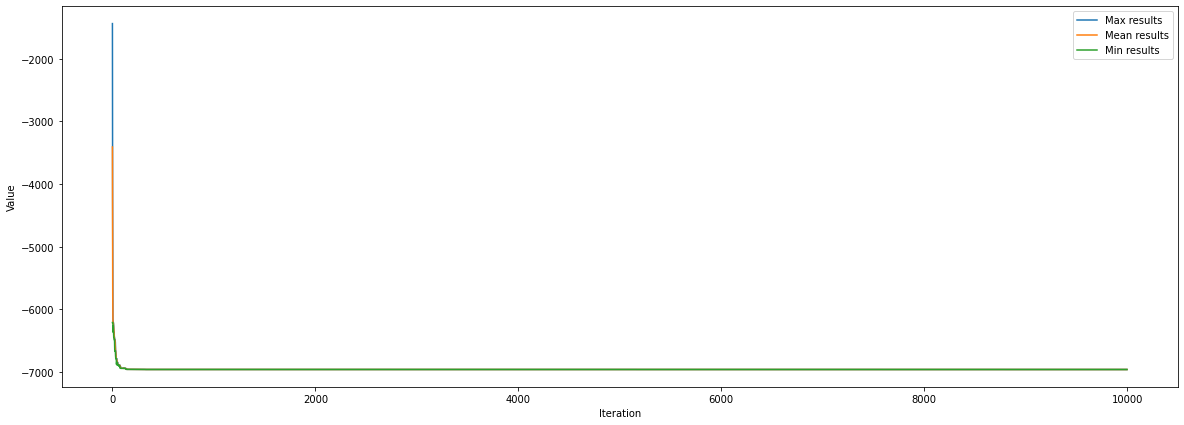

[14.095       0.84296079]


In [48]:
res=constrained_ES_mi_lambda_for_g6(50, 100, is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G8

In [69]:
def G8_restrictions(individual):
    return individual[0] ** 2 + 1 <= individual[1] and 1 + (individual[1] - 4) ** 2 <= individual[0]
constrained_random_population(2, 10, G8_restrictions, (0, 10), (0, 1))

array([[[1.80790053, 4.55121936],
        [0.62978448, 0.43339709]],

       [[1.31897352, 4.5173889 ],
        [0.84962483, 0.18812007]],

       [[1.05263388, 4.18443353],
        [0.09392519, 0.30613323]],

       [[1.19157056, 4.34743652],
        [0.36528084, 0.93515304]],

       [[1.46475645, 3.65611087],
        [0.204989  , 0.13872502]],

       [[1.46752793, 3.99713995],
        [0.89153653, 0.59484904]],

       [[1.69985148, 4.45310791],
        [0.26624537, 0.76309269]],

       [[1.58517692, 4.25759297],
        [0.48937102, 0.52322531]],

       [[1.63801732, 4.55900905],
        [0.6878744 , 0.24928746]],

       [[1.66023572, 4.50349663],
        [0.66411082, 0.45164011]]])

In [70]:
def G8_objective_function(individual):
    return ((np.sin(2 * np.pi * individual[0]) ** 3) * np.sin(2 * np.pi * individual[1])) / (individual[0] ** 4 + (individual[0] ** 3) * individual[1])
G8_objective_function([1.2279713, 4.2453733])

0.09582504141801164

Mi + lambda

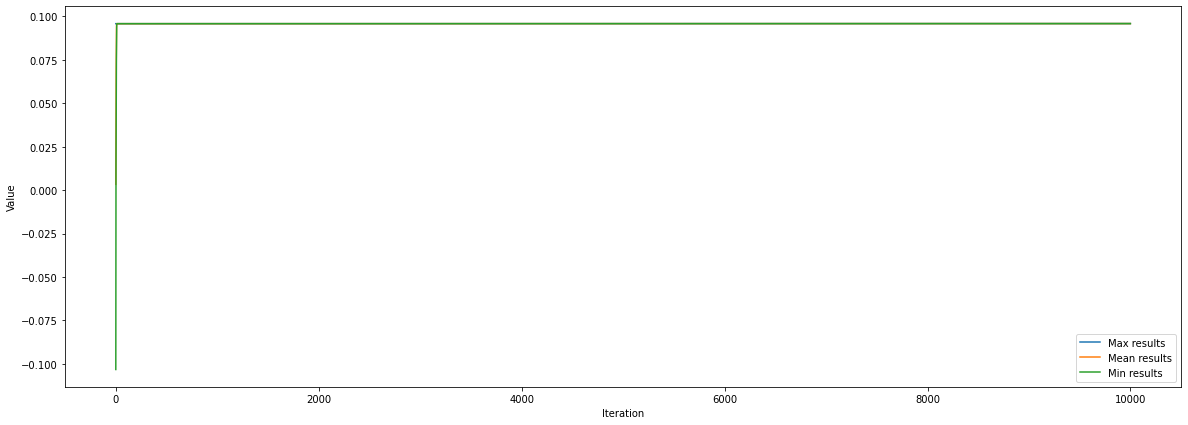

[1.22859597 4.23971633]


In [71]:
res=constrained_ES_mi_lambda(G8_objective_function, 2, 100, 100, G8_restrictions, (0, 10), looking_for_max=True)
plot_chart(res)
print(res[0])

Mi, lambda

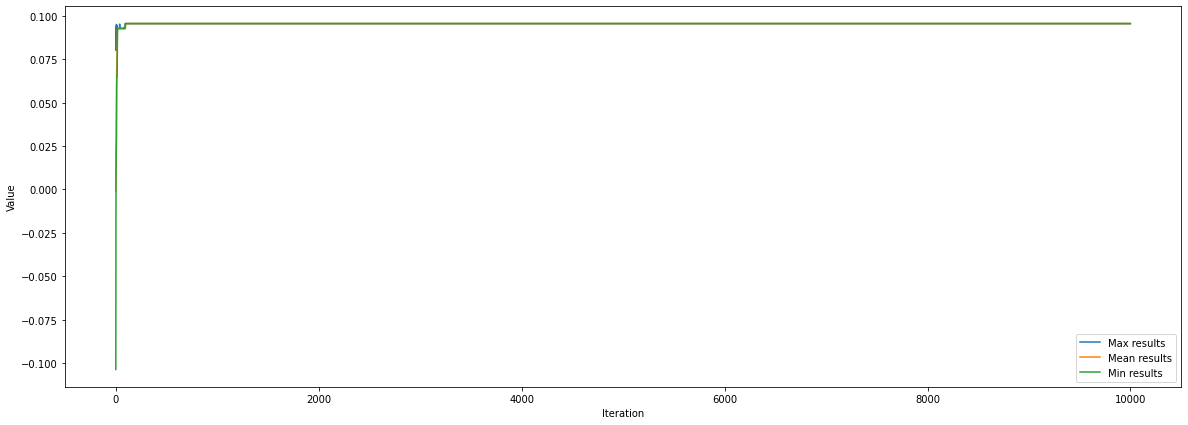

[1.23507937 4.24858916]


In [72]:
res=constrained_ES_mi_lambda(G8_objective_function, 2, 100, 200, G8_restrictions, (0, 10), looking_for_max=True, is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G11

In [53]:
def G11_objective_function(individual):
    return (individual[0] ** 2) + (individual[1] - 1) ** 2

In [54]:
def constrained_random_population_for_g11(mi, s_bounds):
    res=np.full((mi, 2, 2), 0.0)
    for num_of_child in range(mi):
        candidate=np.random.uniform(-1, 1, 1)[0]
        res[num_of_child, 0, :]=np.array([candidate, candidate ** 2])
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], 2)
    return res

In [55]:
def constrained_mutation_for_g11(P_children, tau_param, tau_zero_param, lambda_param):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, 2) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        tmp = P_children[i, 0, :]
        epsilons_for_first_chromosome = (np.random.normal(0, 1, 1) * P_children[i, 1, 0])
        P_children[i, 0, 0] = P_children[i, 0, 0] + epsilons_for_first_chromosome
        P_children[i, 0, 1] =  P_children[i, 0, 0] ** 2
    return P_children

In [56]:
def constrained_ES_mi_lambda_for_g11(mi_param, lambda_param, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*2)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(2))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population_for_g11(mi_param, s_bounds)
    evaluation_result=eval_population(G11_objective_function, P[:, 0, :])
    for i in range(iterations_number):
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation_for_g11(P_children, tau_param, tau_zero_param, lambda_param)
        children_evaluation_result=eval_population(G11_objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda=is_mi_plus_lambda)
    best_index = evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

Mi + lambda

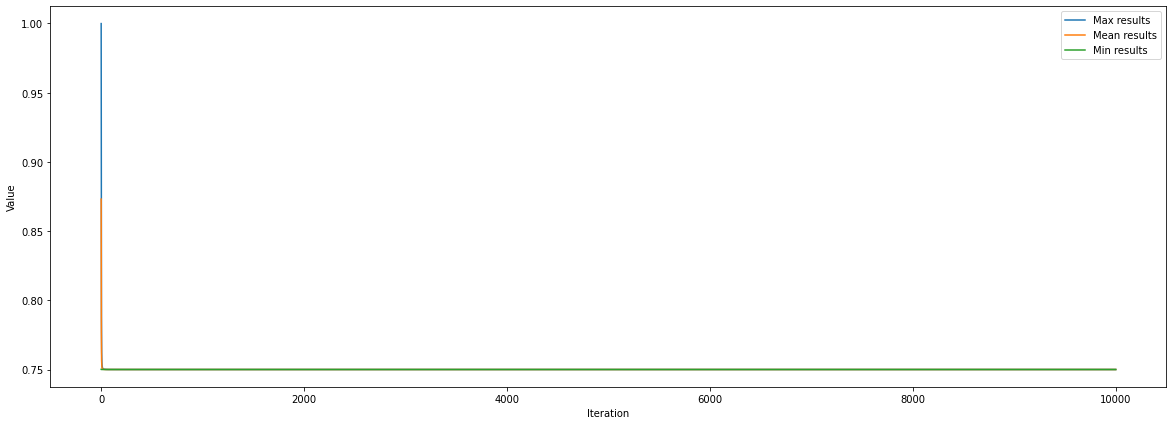

[0.70710656 0.49999969]


In [57]:
res=constrained_ES_mi_lambda_for_g11(100, 100)
plot_chart(res)
print(res[0])

Mi, lambda

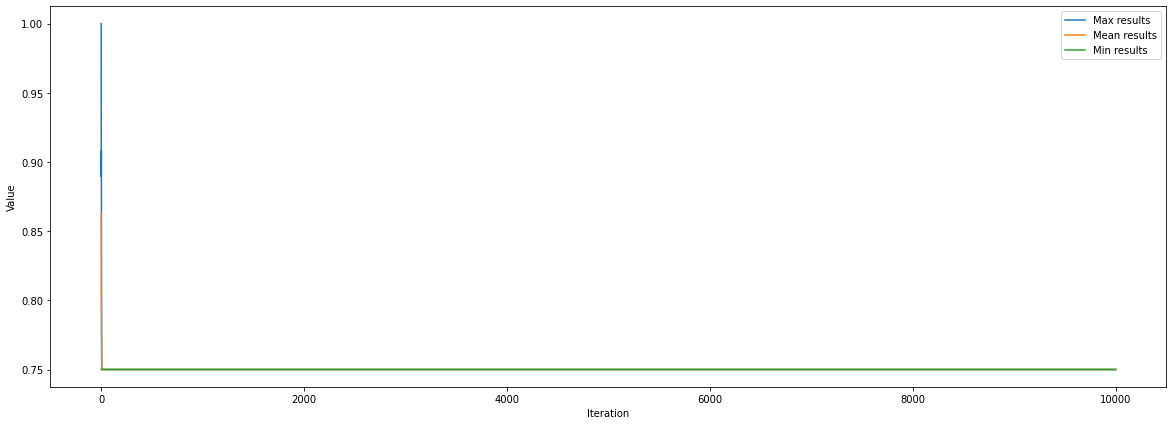

[-0.70710678  0.5       ]


In [58]:
res=constrained_ES_mi_lambda_for_g11(100, 200, is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G12

In [73]:
def G12_restrictions(individual):
    for i in ([np.floor(individual[0]), np.ceil(individual[0])]):
        for j in ([np.floor(individual[1]), np.ceil(individual[1])]):
            for k in ([np.floor(individual[2]), np.ceil(individual[2])]):
                if i > 0 and i < 10 and j > 0 and j < 10 and k > 0 and k < 10 and (individual[0] - i) ** 2 + (individual[1] - j) ** 2 + (individual[2] - k) ** 2 <= 0.0625:
                    return True
    return False
constrained_random_population(3, 10, G12_restrictions, (0, 10), (0, 1))

array([[[1.91577283, 8.20611908, 1.99235175],
        [0.12613018, 0.50326112, 0.64437341]],

       [[7.11224663, 9.18671099, 1.11744198],
        [0.78168198, 0.17669241, 0.59046928]],

       [[0.90639749, 9.07264752, 4.09180295],
        [0.71182481, 0.69585   , 0.36259063]],

       [[3.13044602, 5.86705297, 4.89505524],
        [0.80093612, 0.9029488 , 0.3837645 ]],

       [[5.00174867, 3.06586315, 5.88118822],
        [0.04024869, 0.60329552, 0.76784498]],

       [[4.13515267, 9.08456922, 6.13311099],
        [0.63970025, 0.26162218, 0.20755264]],

       [[8.11010222, 8.07782177, 2.04488056],
        [0.85005376, 0.63820773, 0.63266203]],

       [[1.99193383, 8.86204022, 3.80816954],
        [0.29181806, 0.77643911, 0.02782142]],

       [[7.88932054, 5.86691527, 7.82317481],
        [0.47225659, 0.40658477, 0.85741875]],

       [[7.96889523, 1.95743467, 6.02251752],
        [0.05833562, 0.47059708, 0.99093159]]])

In [74]:
def G12_objective_function(individual):
    return 0.01 * ((individual[0] - 5) ** 2 + (individual[1] - 5) ** 2 + (individual[2] - 5) ** 2) - 1
G12_objective_function(np.array([10.0, 10.0, 10.0]))

-0.25

Mi + lambda

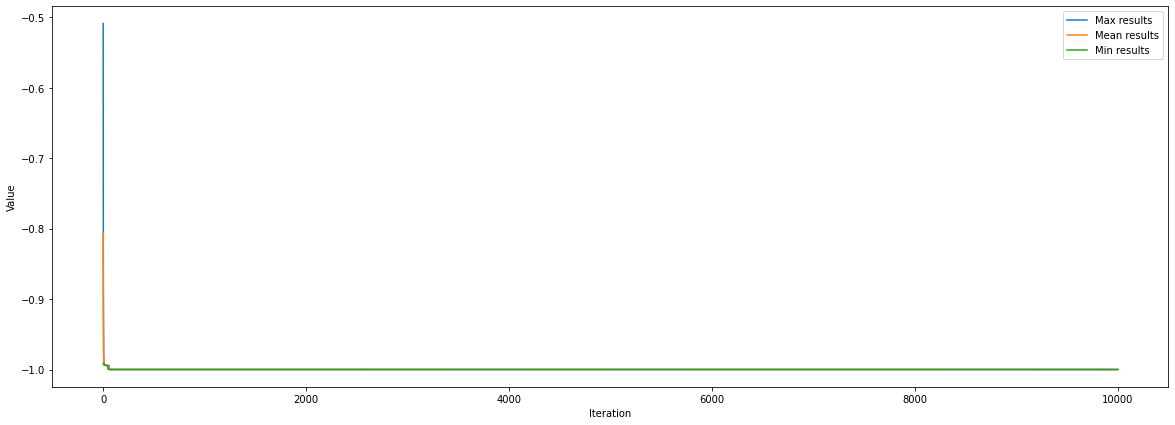

[5.00325459 5.00147603 4.99560087]


In [75]:
res=constrained_ES_mi_lambda(G12_objective_function, 3, 100, 100, G12_restrictions, (0, 10))
plot_chart(res)
print(res[0])

Mi, lambda

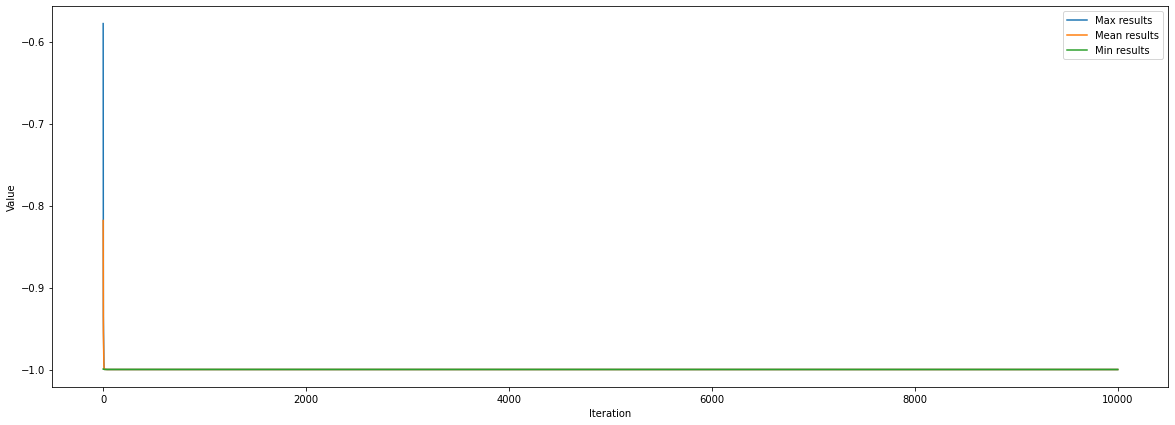

[4.99710102 4.98475968 4.99730998]


In [76]:
res=constrained_ES_mi_lambda(G12_objective_function, 3, 100, 200, G12_restrictions, (0, 10), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])